# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(32,32),self.img.reshape(32,32))

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(32,32),self.img.reshape(32,32))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
model = load_model("CNN_CIFAR10_net3.h5")

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# Prepare Data

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [7]:
X_sc = X_train / 255.0
X_test_sc = X_test / 255.0
y_cat = to_categorical(y_train)

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_sc = grayscale(X_sc)
X_test_sc = grayscale(X_test_sc)
X_train = grayscale(X_train)
X_test = grayscale(X_test)

y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],32,32),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],32,32),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.95842
Test accuracy:  0.8245


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,32,1,10,10,10000)

In [10]:
subsample.shape

(1047, 32, 32, 1)

In [11]:
subsample_y.shape

(1047, 1)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],32,32),axis=3))

In [13]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.8242597898758357


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,32,1,6,10,1047)

In [15]:
original_sc = original / 255.0
y_pred_original = model.predict(np.expand_dims(original_sc.reshape(original_sc.shape[0],32,32),axis=3))
print("Accuracy on original: ", accuracy_score(original_y,np.argmax(y_pred_original,axis=1)))

Accuracy on original:  0.824945295404814


In [16]:
adversarial_sc = adversarial / 255.0
y_pred_adversarial = model.predict(np.expand_dims(adversarial_sc.reshape(adversarial_sc.shape[0],32,32),axis=3))
print("Accuracy on adversarial: ", accuracy_score(adversarial_y,np.argmax(y_pred_adversarial,axis=1)))

Accuracy on adversarial:  0.8195488721804511


In [17]:
original.shape

(914, 32, 32, 1)

In [18]:
adversarial.shape

(133, 32, 32, 1)

In [19]:
adversarial_y.shape

(133, 1)

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((32*32,1)),
    "input_size" : 32*32,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 10, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  [0.85772264] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  [0.85772264] 25
75  :  [0.85772264] 25
100  :  [0.87669265] 25
125  :  [0.89443636] 25
150  :  [0.89443636] 25
175  :  [0.89443636] 25
200  :  [0.89443636] 25
225  :  [0.89730966] 25
250  :  [0.89730966] 25
275  :  [0.89730966] 25
300  :  [0.89853585] 25
325  :  [0.89949894] 25
350  :  [0.9067975] 25
375  :  [0.9079932] 25
400  :  [0.9079932] 25
425  :  [0.9079932] 25
450  :  [0.9079932] 25
475  :  [0.9079932] 25
500  :  [0.9093473] 25
525  :  [0.91321874] 25
550  :  [0.9174563] 25
575  :  [0.9174563] 25
600  :  [0.9196862] 25
625  :  [0.92070246] 25
650  :  [0.92070246] 25
675  :  [0.92082286] 25
700  :  [0.92354226] 25
725  :  [0.9236313] 25
750  :  [0.92395544] 25
775  :  [0.92395544] 25
800  :  [0.92472947] 25
825  :  [0.926104] 25
850  :  [0.926104] 25
875  :  [0.92659545] 25
900  :  [0.9269343] 25
Time:  114.4848313331604  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


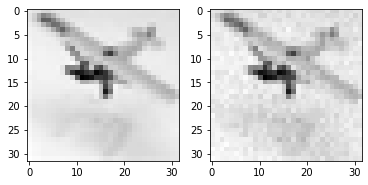

25  :  [0.9315814] 25
50  :  [0.9315814] 25
75  :  [0.9316721] 25
100  :  [0.9316721] 25
125  :  [0.9316721] 25
150  :  [0.9316721] 25
175  :  [0.9341572] 25
200  :  [0.93815863] 25
225  :  [0.93815863] 25
250  :  [0.94115883] 25
275  :  [0.94115883] 25
300  :  [0.9428427] 25
325  :  [0.9428427] 25
350  :  [0.9428427] 25
375  :  [0.94583523] 25
400  :  [0.9495753] 25
425  :  [0.9507129] 25
450  :  [0.9534384] 25
475  :  [0.9538741] 25
500  :  [0.9538741] 25
525  :  [0.9538741] 25
550  :  [0.9538741] 25
575  :  [0.9557948] 25
600  :  [0.9617923] 25
625  :  [0.9617923] 25
650  :  [0.962155] 25
675  :  [0.9629451] 25
700  :  [0.9629451] 25
725  :  [0.9634496] 25
750  :  [0.96369946] 25
775  :  [0.9647191] 25
800  :  [0.9657092] 25
Time:  104.06635546684265  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


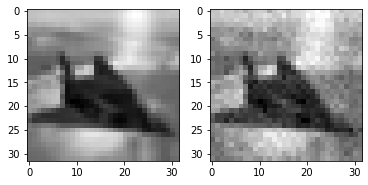

25  :  [0.9156879] 25
50  :  [0.92149764] 25
75  :  [0.927083] 25
100  :  [0.927083] 25
125  :  [0.927083] 25
150  :  [0.927083] 25
175  :  [0.927083] 25
200  :  [0.927083] 25
225  :  [0.927083] 25
250  :  [0.927083] 25
275  :  [0.9278085] 25
300  :  [0.9331435] 25
325  :  [0.9331435] 25
350  :  [0.9331435] 25
375  :  [0.9331435] 25
400  :  [0.9331435] 25
425  :  [0.9331435] 25
450  :  [0.937337] 25
475  :  [0.937337] 25
500  :  [0.93894446] 25
525  :  [0.9431787] 25
550  :  [0.9431787] 25
575  :  [0.9463682] 25
600  :  [0.9482854] 25
625  :  [0.95157576] 25
650  :  [0.95162964] 25
675  :  [0.95162964] 25
700  :  [0.9523057] 25
725  :  [0.9523057] 25
750  :  [0.9523057] 25
775  :  [0.9543536] 25
800  :  [0.95463836] 25
Time:  106.58551907539368  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


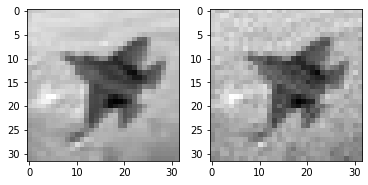

25  :  [0.9474461] 25
50  :  [0.9474461] 25
75  :  [0.9474461] 25
100  :  [0.9474461] 25
125  :  [0.94954985] 25
150  :  [0.9495927] 25
175  :  [0.9495927] 25
200  :  [0.9495927] 25
225  :  [0.9495927] 25
250  :  [0.9495927] 25
275  :  [0.9495927] 25
300  :  [0.9495927] 25
325  :  [0.9495927] 25
350  :  [0.9495927] 25
375  :  [0.9495927] 25
400  :  [0.9495927] 25
425  :  [0.9495927] 25
450  :  [0.9495927] 25
475  :  [0.9530041] 25
500  :  [0.9530041] 25
525  :  [0.9530935] 25
550  :  [0.95691264] 25
575  :  [0.95691264] 25
600  :  [0.95691264] 25
625  :  [0.9595604] 25
650  :  [0.9595604] 25
675  :  [0.9595604] 25
700  :  [0.9595604] 25
725  :  [0.96097815] 25
750  :  [0.9610293] 25
775  :  [0.9639785] 25
800  :  [0.9639785] 25
Time:  103.74768924713135  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


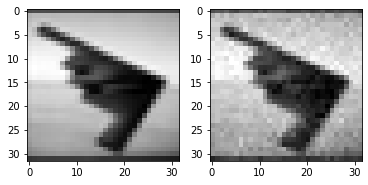

25  :  [0.8532138] 25
50  :  [0.8532138] 25
75  :  [0.8593057] 25
100  :  [0.8597487] 25
125  :  [0.8597487] 25
150  :  [0.8617632] 25
175  :  [0.8666307] 25
200  :  [0.86847055] 25
225  :  [0.8727884] 25
250  :  [0.8743402] 25
275  :  [0.8743402] 25
300  :  [0.8743402] 25
325  :  [0.8743402] 25
350  :  [0.87475] 25
375  :  [0.87475] 25
400  :  [0.8760936] 25
425  :  [0.87656784] 25
450  :  [0.8774579] 25
475  :  [0.8786134] 25
500  :  [0.8786628] 25
525  :  [0.8796442] 25
550  :  [0.8796442] 25
575  :  [0.8809021] 25
600  :  [0.8817613] 25
625  :  [0.8818816] 25
650  :  [0.8827699] 25
675  :  [0.8831645] 25
700  :  [0.88319737] 25
725  :  [0.8843991] 25
750  :  [0.8843991] 25
775  :  [0.8843991] 25
800  :  [0.8849335] 25
Time:  103.09713554382324  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


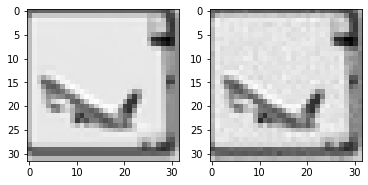

25  :  [0.7334582] 25
50  :  [0.7334582] 25
75  :  [0.73414415] 25
100  :  [0.74201196] 25
125  :  [0.74201196] 25
150  :  [0.7421584] 25
175  :  [0.74564165] 25
200  :  [0.74564165] 25
225  :  [0.7467352] 25
250  :  [0.7538615] 25
275  :  [0.7566173] 25
300  :  [0.7566173] 25
325  :  [0.759996] 25
350  :  [0.7605845] 25
375  :  [0.7630408] 25
400  :  [0.7703578] 25
425  :  [0.7714883] 25
450  :  [0.7714883] 25
475  :  [0.7816794] 25
500  :  [0.7816794] 25
525  :  [0.7816794] 25
550  :  [0.79018146] 25
575  :  [0.79041326] 25
600  :  [0.79083693] 25
625  :  [0.792494] 25
650  :  [0.8009578] 25
675  :  [0.8009578] 25
700  :  [0.80169916] 25
725  :  [0.8021722] 25
750  :  [0.8075818] 25
775  :  [0.80769] 25
800  :  [0.8089637] 25
825  :  [0.80924326] 25
850  :  [0.80924326] 25
875  :  [0.809284] 25
900  :  [0.8098234] 25
925  :  [0.8098234] 25
950  :  [0.8105242] 25
975  :  [0.8105242] 25
1000  :  [0.81084985] 25
1025  :  [0.81108856] 25
1050  :  [0.811107] 25
1075  :  [0.811107] 25
1100

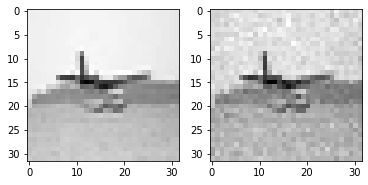

25  :  [0.7720727] 25
50  :  [0.8397404] 25
75  :  [0.8399616] 25
100  :  [0.8399616] 25
125  :  [0.8399616] 25
150  :  [0.8399616] 25
175  :  [0.8399616] 25
200  :  [0.8399616] 25
225  :  [0.8399616] 25
250  :  [0.8399616] 25
275  :  [0.8399616] 25
300  :  [0.8399616] 25
325  :  [0.8455502] 25
350  :  [0.84561765] 25
375  :  [0.84561765] 25
400  :  [0.84561765] 25
425  :  [0.84561765] 25
450  :  [0.8474963] 25
475  :  [0.8476361] 25
500  :  [0.8476361] 25
525  :  [0.84972817] 25
550  :  [0.850901] 25
575  :  [0.8509244] 25
600  :  [0.85107154] 25
625  :  [0.8533655] 25
650  :  [0.85585475] 25
675  :  [0.85585475] 25
700  :  [0.85618013] 25
725  :  [0.8561802] 25
750  :  [0.8570409] 25
775  :  [0.8570409] 25
800  :  [0.8578276] 25
825  :  [0.8578445] 25
Time:  105.67536878585815  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


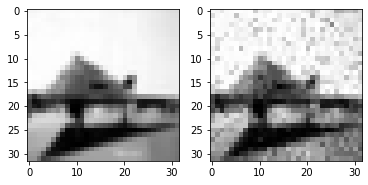

25  :  [0.835513] 25
50  :  [0.9203342] 25
75  :  [0.9130577] 25
100  :  [0.9130577] 25
125  :  [0.9130577] 25
150  :  [0.9161071] 25
175  :  [0.9162392] 25
200  :  [0.9162392] 25
225  :  [0.9162392] 25
250  :  [0.9162392] 25
275  :  [0.92517495] 25
300  :  [0.92517495] 25
325  :  [0.92517495] 25
350  :  [0.93013966] 25
375  :  [0.93013966] 25
400  :  [0.9362198] 25
425  :  [0.9362198] 25
450  :  [0.9388231] 25
475  :  [0.9387032] 25
500  :  [0.94154775] 25
525  :  [0.94154775] 25
550  :  [0.94367224] 25
575  :  [0.94378555] 25
600  :  [0.948418] 25
625  :  [0.94990253] 25
650  :  [0.9547213] 25
675  :  [0.9547213] 25
700  :  [0.9547213] 25
725  :  [0.95546496] 25
750  :  [0.9569081] 25
775  :  [0.95844734] 25
800  :  [0.95844734] 25
825  :  [0.95844734] 25
Time:  106.6788718700409  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


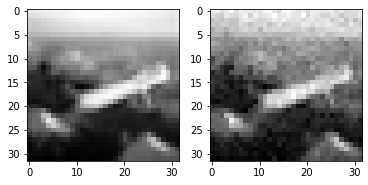

25  :  [0.7843218] 25
50  :  [0.7843218] 25
75  :  [0.78205705] 25
100  :  [0.78096294] 25
125  :  [0.80164945] 25
150  :  [0.81279016] 25
175  :  [0.8123797] 25
200  :  [0.8288584] 25
225  :  [0.829558] 25
250  :  [0.829558] 25
275  :  [0.829558] 25
300  :  [0.829558] 25
325  :  [0.829558] 25
350  :  [0.829558] 25
375  :  [0.83218765] 25
400  :  [0.8335264] 25
425  :  [0.8335264] 25
450  :  [0.8335264] 25
475  :  [0.8338945] 25
500  :  [0.84206563] 25
525  :  [0.8420871] 25
550  :  [0.8420871] 25
575  :  [0.84280646] 25
600  :  [0.84312624] 25
625  :  [0.8524198] 25
650  :  [0.85526127] 25
675  :  [0.8669565] 25
700  :  [0.8669565] 25
725  :  [0.86744356] 25
750  :  [0.86953104] 25
775  :  [0.87356424] 25
800  :  [0.8764324] 25
825  :  [0.8764324] 25
850  :  [0.8784566] 25
875  :  [0.8784566] 25
900  :  [0.8796066] 25
925  :  [0.8796066] 25
950  :  [0.8811389] 25
975  :  [0.8811389] 25
1000  :  [0.8815276] 25
1025  :  [0.8815276] 25
1050  :  [0.8815276] 25
1075  :  [0.8818899] 25
1100

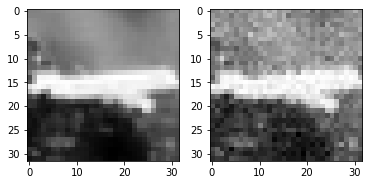

25  :  [0.8417201] 25
50  :  [0.8464494] 25
75  :  [0.86805713] 25
100  :  [0.8757152] 25
125  :  [0.87839955] 25
150  :  [0.87839955] 25
175  :  [0.8811548] 25
200  :  [0.9008155] 25
225  :  [0.9008155] 25
250  :  [0.9061816] 25
275  :  [0.90619344] 25
300  :  [0.9079297] 25
325  :  [0.90912396] 25
350  :  [0.91578674] 25
375  :  [0.91578674] 25
400  :  [0.91578674] 25
425  :  [0.91578674] 25
450  :  [0.9186766] 25
475  :  [0.92076] 25
500  :  [0.92076] 25
525  :  [0.9279506] 25
550  :  [0.9279506] 25
575  :  [0.9279506] 25
600  :  [0.9283719] 25
625  :  [0.9283719] 25
650  :  [0.9283719] 25
675  :  [0.9283719] 25
700  :  [0.9289001] 25
725  :  [0.9289001] 25
750  :  [0.9293999] 25
775  :  [0.9300475] 25
800  :  [0.9314837] 25
825  :  [0.9314837] 25
850  :  [0.9314837] 25
875  :  [0.9316327] 25
900  :  [0.932257] 25
925  :  [0.9330498] 25
950  :  [0.9330498] 25
975  :  [0.9334992] 25
Time:  122.37870383262634  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for

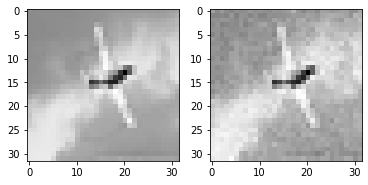

25  :  [0.8324198] 25
50  :  [0.8870116] 25
75  :  [0.909585] 25
100  :  [0.9094809] 25
125  :  [0.9094809] 25
150  :  [0.9094809] 25
175  :  [0.9094809] 25
200  :  [0.9094809] 25
225  :  [0.9094809] 25
250  :  [0.9094809] 25
275  :  [0.9094809] 25
300  :  [0.9094809] 25
325  :  [0.9094809] 25
350  :  [0.92088366] 25
375  :  [0.92088366] 25
400  :  [0.9241646] 25
425  :  [0.9241646] 25
450  :  [0.9241646] 25
475  :  [0.9241646] 25
500  :  [0.9241646] 25
525  :  [0.9241646] 25
550  :  [0.9241646] 25
575  :  [0.9241646] 25
600  :  [0.9241646] 25
625  :  [0.9273915] 25
650  :  [0.9273915] 25
675  :  [0.9273915] 25
700  :  [0.9273915] 25
725  :  [0.9273915] 25
750  :  [0.93204486] 25
775  :  [0.93204486] 25
800  :  [0.93784463] 25
825  :  [0.93784463] 25
850  :  [0.93784463] 25
875  :  [0.93853706] 25
900  :  [0.94112426] 25
925  :  [0.94112426] 25
950  :  [0.94112426] 25
975  :  [0.94112426] 25
1000  :  [0.94207597] 25
1025  :  [0.94287664] 25
1050  :  [0.9431455] 25
1075  :  [0.9431455] 

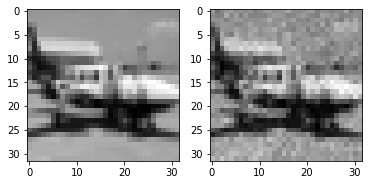

25  :  [0.8878211] 25
50  :  [0.8878211] 25
75  :  [0.8878211] 25
100  :  [0.91023827] 25
125  :  [0.91023827] 25
150  :  [0.9107001] 25
175  :  [0.9243804] 25
200  :  [0.9243804] 25
225  :  [0.93133366] 25
250  :  [0.9429193] 25
275  :  [0.9429193] 25
300  :  [0.9429193] 25
325  :  [0.9498397] 25
350  :  [0.9533585] 25
375  :  [0.9533585] 25
400  :  [0.9547726] 25
425  :  [0.9646081] 25
450  :  [0.9646081] 25
475  :  [0.9646081] 25
500  :  [0.9646081] 25
525  :  [0.96762085] 25
550  :  [0.96762085] 25
575  :  [0.96762085] 25
600  :  [0.9676332] 25
625  :  [0.96765435] 25
650  :  [0.967907] 25
675  :  [0.968949] 25
700  :  [0.9700475] 25
725  :  [0.9701335] 25
750  :  [0.97065234] 25
775  :  [0.9709228] 25
800  :  [0.9709228] 25
825  :  [0.9709228] 25
850  :  [0.971244] 25
875  :  [0.9718728] 25
900  :  [0.9718728] 25
925  :  [0.9720606] 25
950  :  [0.9721773] 25
975  :  [0.9722506] 25
1000  :  [0.97237307] 25
1025  :  [0.97246295] 25
Time:  126.6880931854248  seconds
Original class:  

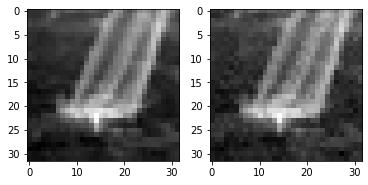

25  :  [0.92394084] 25
50  :  [0.92394084] 25
75  :  [0.9237358] 25
100  :  [0.9237358] 25
125  :  [0.93683684] 25
150  :  [0.93698275] 25
175  :  [0.93698275] 25
200  :  [0.93698275] 25
225  :  [0.9460548] 25
250  :  [0.9460548] 25
275  :  [0.9481878] 25
300  :  [0.9482246] 25
325  :  [0.9482246] 25
350  :  [0.9482246] 25
375  :  [0.9482246] 25
400  :  [0.95028496] 25
425  :  [0.95026785] 25
450  :  [0.95026785] 25
475  :  [0.9509215] 25
500  :  [0.95153874] 25
525  :  [0.9572885] 25
550  :  [0.9572885] 25
575  :  [0.9575128] 25
600  :  [0.9575128] 25
625  :  [0.9589388] 25
650  :  [0.9589388] 25
675  :  [0.9589388] 25
700  :  [0.9589388] 25
725  :  [0.9591661] 25
750  :  [0.9591661] 25
775  :  [0.95994735] 25
800  :  [0.95994735] 25
825  :  [0.95994735] 25
850  :  [0.9602485] 25
875  :  [0.96053] 25
900  :  [0.960871] 25
Time:  114.57564115524292  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


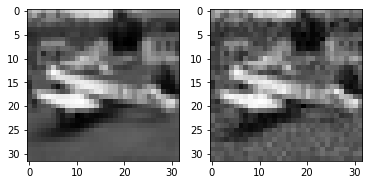

25  :  [0.9182161] 25
50  :  [0.9182161] 25
75  :  [0.90536416] 25
100  :  [0.9059794] 25
125  :  [0.9083327] 25
150  :  [0.92112947] 25
175  :  [0.9219024] 25
200  :  [0.921968] 25
225  :  [0.921968] 25
250  :  [0.921968] 25
275  :  [0.921968] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


300  :  [0.921968] 25
325  :  [0.921968] 25
350  :  [0.921968] 25
375  :  [0.921968] 25
400  :  [0.921968] 25
425  :  [0.921968] 25
450  :  [0.921968] 25
475  :  [0.921968] 25
500  :  [0.921968] 25
525  :  [0.921968] 25
550  :  [0.921968] 25
575  :  [0.921968] 25
600  :  [0.921968] 25
625  :  [0.921968] 25
650  :  [0.921968] 25
675  :  [0.921968] 25
700  :  [0.921968] 25
725  :  [0.921968] 25
750  :  [0.921968] 25
775  :  [0.921968] 25
800  :  [0.921968] 25
825  :  [0.921968] 25
850  :  [0.921968] 25
875  :  [0.921968] 25
900  :  [0.921968] 25
925  :  [0.921968] 25
Time:  113.88525605201721  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


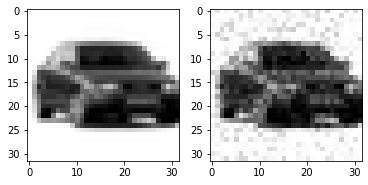

25  :  [0.96344304] 25
50  :  [0.96344304] 25
75  :  [0.96344304] 25
100  :  [0.96344304] 25
125  :  [0.96344304] 25
150  :  [0.96344304] 25
175  :  [0.96344304] 25
200  :  [0.96344304] 25
225  :  [0.96713954] 25
250  :  [0.96713954] 25
275  :  [0.96713954] 25
300  :  [0.96713954] 25
325  :  [0.96806556] 25
350  :  [0.96806556] 25
375  :  [0.96806556] 25
400  :  [0.96806556] 25
425  :  [0.96911526] 25
450  :  [0.96911526] 25
475  :  [0.9729252] 25
500  :  [0.9729252] 25
525  :  [0.97315365] 25
550  :  [0.9757654] 25
575  :  [0.9804338] 25
600  :  [0.9804338] 25
625  :  [0.9804338] 25
650  :  [0.9804338] 25
675  :  [0.9804338] 25
700  :  [0.9804338] 25
725  :  [0.9807484] 25
750  :  [0.9808316] 25
775  :  [0.9809039] 25
800  :  [0.9832423] 25
Time:  98.26936650276184  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [2]


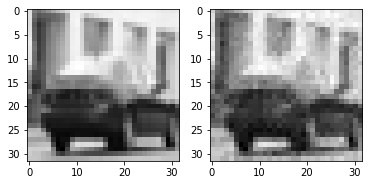

25  :  [0.87231386] 25
50  :  [0.87231386] 25
75  :  [0.8735847] 25
100  :  [0.87488925] 25
125  :  [0.87488925] 25
150  :  [0.87488925] 25
175  :  [0.87488925] 25
200  :  [0.87964314] 25
225  :  [0.8801768] 25
250  :  [0.8801768] 25
275  :  [0.8801768] 25
300  :  [0.8852126] 25
325  :  [0.88597333] 25
350  :  [0.88597333] 25
375  :  [0.88597333] 25
400  :  [0.88597333] 25
425  :  [0.8875177] 25
450  :  [0.8901036] 25
475  :  [0.8917327] 25
500  :  [0.89592695] 25
525  :  [0.90392184] 25
550  :  [0.90392184] 25
575  :  [0.90392184] 25
600  :  [0.90392184] 25
625  :  [0.90392184] 25
650  :  [0.90467656] 25
675  :  [0.9047932] 25
700  :  [0.9052443] 25
725  :  [0.9052443] 25
750  :  [0.90693736] 25
775  :  [0.90694857] 25
800  :  [0.90694857] 25
Time:  98.42068362236023  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


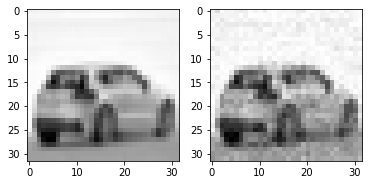

25  :  [0.8856722] 25
50  :  [0.89961076] 25
75  :  [0.88310057] 25
100  :  [0.88310057] 25
125  :  [0.88513684] 25
150  :  [0.89145863] 25
175  :  [0.90178] 25
200  :  [0.9018928] 25
225  :  [0.90914345] 25
250  :  [0.9197421] 25
275  :  [0.9196977] 25
300  :  [0.92771196] 25
325  :  [0.92771196] 25
350  :  [0.92771196] 25
375  :  [0.92771196] 25
400  :  [0.92950857] 25
425  :  [0.9425703] 25
450  :  [0.9425703] 25
475  :  [0.9527147] 25
500  :  [0.9527147] 25
525  :  [0.9533285] 25
550  :  [0.9555681] 25
575  :  [0.9613372] 25
600  :  [0.9613372] 25
625  :  [0.96388984] 25
650  :  [0.9649857] 25
675  :  [0.9649857] 25
700  :  [0.96602416] 25
725  :  [0.96713185] 25
750  :  [0.96713185] 25
775  :  [0.9678492] 25
800  :  [0.9683231] 25
825  :  [0.968819] 25
850  :  [0.96894944] 25
875  :  [0.96894944] 25
900  :  [0.9692196] 25
925  :  [0.9696112] 25
950  :  [0.9696112] 25
975  :  [0.96975935] 25
1000  :  [0.9702193] 25
1025  :  [0.97024244] 25
1050  :  [0.97035706] 25
1075  :  [0.97047

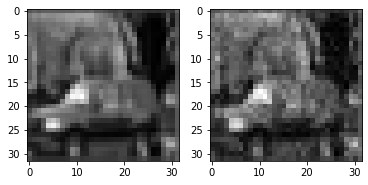

25  :  [0.9073665] 25
50  :  [0.9073665] 25
75  :  [0.9305035] 25
100  :  [0.9305035] 25
125  :  [0.9305035] 25
150  :  [0.9325335] 25
175  :  [0.9325335] 25
200  :  [0.9325335] 25
225  :  [0.93280625] 25
250  :  [0.93382883] 25
275  :  [0.9338027] 25
300  :  [0.9366071] 25
325  :  [0.93753266] 25
350  :  [0.9433391] 25
375  :  [0.9496753] 25
400  :  [0.9496753] 25
425  :  [0.9527919] 25
450  :  [0.9527919] 25
475  :  [0.9527919] 25
500  :  [0.95462286] 25
525  :  [0.95590734] 25
550  :  [0.9579395] 25
575  :  [0.9579395] 25
600  :  [0.96131647] 25
625  :  [0.9645312] 25
650  :  [0.9651184] 25
675  :  [0.96604884] 25
700  :  [0.96604884] 25
725  :  [0.96604884] 25
750  :  [0.96608233] 25
775  :  [0.96745205] 25
800  :  [0.9685855] 25
825  :  [0.96859306] 25
850  :  [0.96893954] 25
Time:  106.66323351860046  seconds
Original class:  1
Prediction for normal image:  [6]
Prediction for adversarial image:  [6]


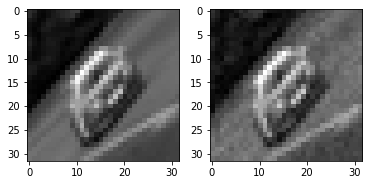

25  :  [0.9043061] 25
50  :  [0.9043061] 25
75  :  [0.9043061] 25
100  :  [0.92937016] 25
125  :  [0.93070793] 25
150  :  [0.93070793] 25
175  :  [0.93070793] 25
200  :  [0.93070793] 25
225  :  [0.93070793] 25
250  :  [0.93070793] 25
275  :  [0.9400188] 25
300  :  [0.9400188] 25
325  :  [0.9575716] 25
350  :  [0.9575716] 25
375  :  [0.9575716] 25
400  :  [0.9626034] 25
425  :  [0.9626034] 25
450  :  [0.9626034] 25
475  :  [0.9626034] 25
500  :  [0.9626034] 25
525  :  [0.9626034] 25
550  :  [0.9642713] 25
575  :  [0.9658675] 25
600  :  [0.9658675] 25
625  :  [0.9658675] 25
650  :  [0.9658675] 25
675  :  [0.9659523] 25
700  :  [0.966961] 25
725  :  [0.966961] 25
750  :  [0.966961] 25
775  :  [0.966961] 25
800  :  [0.96712184] 25
825  :  [0.96776205] 25
850  :  [0.96881306] 25
875  :  [0.96910703] 25
900  :  [0.9692898] 25
925  :  [0.9695484] 25
950  :  [0.96977204] 25
975  :  [0.96977204] 25
1000  :  [0.9699187] 25
1025  :  [0.97002435] 25
1050  :  [0.97002435] 25
1075  :  [0.97003686] 2

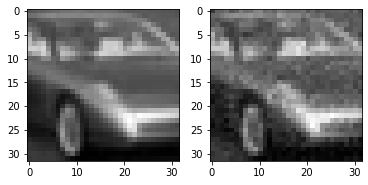

25  :  [0.70354784] 25
50  :  [0.84020716] 25
75  :  [0.828723] 25
100  :  [0.8272309] 25
125  :  [0.8272309] 25
150  :  [0.8272309] 25
175  :  [0.8272309] 25
200  :  [0.843971] 25
225  :  [0.8521929] 25
250  :  [0.8521929] 25
275  :  [0.8521929] 25
300  :  [0.8521929] 25
325  :  [0.8521929] 25
350  :  [0.863971] 25
375  :  [0.8656267] 25
400  :  [0.8656267] 25
425  :  [0.8656267] 25
450  :  [0.8656267] 25
475  :  [0.8656267] 25
500  :  [0.8656267] 25
525  :  [0.8656267] 25
550  :  [0.8659927] 25
575  :  [0.87302125] 25
600  :  [0.87302125] 25
625  :  [0.8761692] 25
650  :  [0.87354696] 25
675  :  [0.87354696] 25
700  :  [0.8935592] 25
725  :  [0.8929765] 25
750  :  [0.8940007] 25
775  :  [0.8974223] 25
800  :  [0.8974223] 25
825  :  [0.90983176] 25
850  :  [0.9103288] 25
875  :  [0.9103288] 25
900  :  [0.9103288] 25
925  :  [0.9103288] 25
950  :  [0.9118541] 25
975  :  [0.9118541] 25
1000  :  [0.9118541] 25
1025  :  [0.9118541] 25
1050  :  [0.9118541] 25
1075  :  [0.9118541] 25
1100  

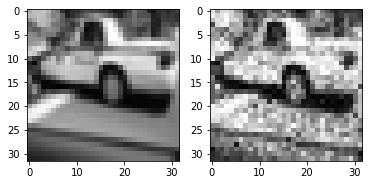

25  :  [0.8885108] 25
50  :  [0.8885108] 25
75  :  [0.8941945] 25
100  :  [0.91664994] 25
125  :  [0.9172951] 25
150  :  [0.9172951] 25
175  :  [0.9172951] 25
200  :  [0.9172951] 25
225  :  [0.91731894] 25
250  :  [0.920046] 25
275  :  [0.9200833] 25
300  :  [0.9200833] 25
325  :  [0.9200833] 25
350  :  [0.9200833] 25
375  :  [0.9236523] 25
400  :  [0.9236523] 25
425  :  [0.9334378] 25
450  :  [0.9334378] 25
475  :  [0.9345419] 25
500  :  [0.9345419] 25
525  :  [0.9345419] 25
550  :  [0.9345419] 25
575  :  [0.93459165] 25
600  :  [0.93991506] 25
625  :  [0.93991506] 25
650  :  [0.9400904] 25
675  :  [0.9400904] 25
700  :  [0.94040203] 25
725  :  [0.9407354] 25
750  :  [0.9407354] 25
775  :  [0.9435942] 25
800  :  [0.9435942] 25
825  :  [0.9444822] 25
850  :  [0.9444822] 25
875  :  [0.94594276] 25
Time:  107.63779783248901  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [2]


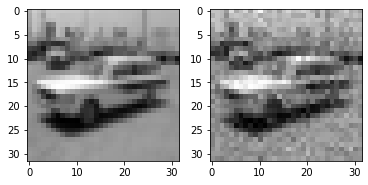

25  :  [0.8308687] 25
50  :  [0.87363255] 25
75  :  [0.91994303] 25
100  :  [0.91994303] 25
125  :  [0.91994303] 25
150  :  [0.91994303] 25
175  :  [0.91994303] 25
200  :  [0.92080104] 25
225  :  [0.9336065] 25
250  :  [0.9336065] 25
275  :  [0.9336065] 25
300  :  [0.94064665] 25
325  :  [0.94064665] 25
350  :  [0.94064665] 25
375  :  [0.94064665] 25
400  :  [0.94139504] 25
425  :  [0.94147545] 25
450  :  [0.9457282] 25
475  :  [0.9457128] 25
500  :  [0.94694567] 25
525  :  [0.9469516] 25
550  :  [0.9495809] 25
575  :  [0.9495809] 25
600  :  [0.9495809] 25
625  :  [0.9495809] 25
650  :  [0.9502679] 25
675  :  [0.9507147] 25
700  :  [0.9510161] 25
725  :  [0.95228636] 25
750  :  [0.9523821] 25
775  :  [0.9523821] 25
800  :  [0.9523821] 25
825  :  [0.9523821] 25
850  :  [0.95254225] 25
875  :  [0.9533662] 25
900  :  [0.9533662] 25
925  :  [0.9533662] 25
950  :  [0.9533662] 25
975  :  [0.9533662] 25
1000  :  [0.95340973] 25
Time:  125.10401177406311  seconds
Original class:  1
Prediction 

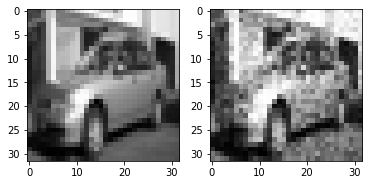

25  :  [0.95915437] 25
50  :  [0.95915437] 25
75  :  [0.95915437] 25
100  :  [0.9609812] 25
125  :  [0.9613946] 25
150  :  [0.9613946] 25
175  :  [0.9616276] 25
200  :  [0.9634556] 25
225  :  [0.96564543] 25
250  :  [0.9694119] 25
275  :  [0.9694119] 25
300  :  [0.9694119] 25
325  :  [0.9694119] 25
350  :  [0.9694119] 25
375  :  [0.97190356] 25
400  :  [0.97190356] 25
425  :  [0.97190356] 25
450  :  [0.97297215] 25
475  :  [0.9740137] 25
500  :  [0.97401386] 25
525  :  [0.97401386] 25
550  :  [0.97401386] 25
575  :  [0.97401386] 25
600  :  [0.97401386] 25
625  :  [0.97401386] 25
650  :  [0.97401386] 25
675  :  [0.97401386] 25
700  :  [0.97401386] 25
725  :  [0.97708774] 25
750  :  [0.97708774] 25
775  :  [0.97708774] 25
800  :  [0.97708774] 25
Time:  98.4379014968872  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


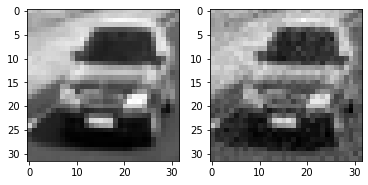

25  :  [0.9169513] 25
50  :  [0.9169513] 25
75  :  [0.9169513] 25
100  :  [0.9169513] 25
125  :  [0.9169513] 25
150  :  [0.9177064] 25
175  :  [0.91759] 25
200  :  [0.91759] 25
225  :  [0.9307606] 25
250  :  [0.93297523] 25
275  :  [0.93297523] 25
300  :  [0.93297523] 25
325  :  [0.93297523] 25
350  :  [0.93297523] 25
375  :  [0.9395009] 25
400  :  [0.9395009] 25
425  :  [0.9429137] 25
450  :  [0.9429137] 25
475  :  [0.9441296] 25
500  :  [0.9489659] 25
525  :  [0.9489659] 25
550  :  [0.9510807] 25
575  :  [0.9510915] 25
600  :  [0.9510915] 25
625  :  [0.9510915] 25
650  :  [0.9510915] 25
675  :  [0.9510915] 25
700  :  [0.9518094] 25
725  :  [0.95182335] 25
750  :  [0.95397836] 25
775  :  [0.95397836] 25
800  :  [0.95397836] 25
825  :  [0.95397836] 25
850  :  [0.9560487] 25
875  :  [0.9560487] 25
900  :  [0.95648265] 25
925  :  [0.95659363] 25
950  :  [0.95833415] 25
975  :  [0.9603553] 25
1000  :  [0.9603553] 25
Time:  123.47202229499817  seconds
Original class:  1
Prediction for norm

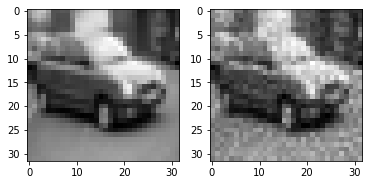

25  :  [0.9359149] 25
50  :  [0.9359149] 25
75  :  [0.93605876] 25
100  :  [0.93605876] 25
125  :  [0.93605876] 25
150  :  [0.93605876] 25
175  :  [0.93605876] 25
200  :  [0.93605876] 25
225  :  [0.93605876] 25
250  :  [0.93605876] 25
275  :  [0.93605876] 25
300  :  [0.93605876] 25
325  :  [0.93605876] 25
350  :  [0.93605876] 25
375  :  [0.93605876] 25
400  :  [0.93605876] 25
425  :  [0.93605876] 25
450  :  [0.93605876] 25
475  :  [0.93605876] 25
500  :  [0.93605876] 25
525  :  [0.93605876] 25
550  :  [0.93605876] 25
575  :  [0.93605876] 25
600  :  [0.93605876] 25
625  :  [0.93605876] 25
650  :  [0.93605876] 25
675  :  [0.93605876] 25
700  :  [0.93605876] 25
725  :  [0.93615067] 25
750  :  [0.93615067] 25
775  :  [0.93615067] 25
800  :  [0.93615067] 25
Time:  98.34945249557495  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


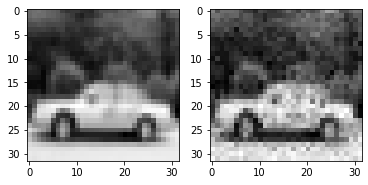

25  :  [0.82910126] 25
50  :  [0.82910126] 25
75  :  [0.79795706] 25
100  :  [0.79795706] 25
125  :  [0.79795706] 25
150  :  [0.86293465] 25
175  :  [0.84394324] 25
200  :  [0.84394324] 25
225  :  [0.84394324] 25
250  :  [0.84394324] 25
275  :  [0.84394324] 25
300  :  [0.84394324] 25
325  :  [0.84394324] 25
350  :  [0.84394324] 25
375  :  [0.84394324] 25
400  :  [0.84394324] 25
425  :  [0.84394324] 25
450  :  [0.84394324] 25
475  :  [0.84394324] 25
500  :  [0.84394324] 25
525  :  [0.84394324] 25
550  :  [0.84394324] 25
575  :  [0.84394324] 25
600  :  [0.84394324] 25
625  :  [0.84394324] 25
650  :  [0.8463385] 25
675  :  [0.8644141] 25
700  :  [0.86857176] 25
725  :  [0.8707922] 25
750  :  [0.8707922] 25
775  :  [0.8707922] 25
800  :  [0.8707922] 25
825  :  [0.8707922] 25
850  :  [0.8707922] 25
875  :  [0.8825659] 25
900  :  [0.8825659] 25
925  :  [0.8825659] 25
950  :  [0.8885671] 25
975  :  [0.8885671] 25
1000  :  [0.89373827] 25
1025  :  [0.8939761] 25
1050  :  [0.8939761] 25
1075  :

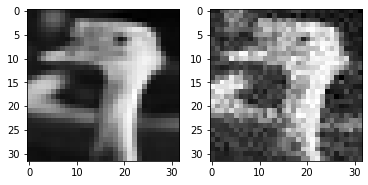

25  :  [0.9211328] 25
50  :  [0.92312205] 25
75  :  [0.92347383] 25
100  :  [0.9309361] 25
125  :  [0.9309361] 25
150  :  [0.9309361] 25
175  :  [0.93741834] 25
200  :  [0.9501587] 25
225  :  [0.9501587] 25
250  :  [0.9501587] 25
275  :  [0.9501587] 25
300  :  [0.9501587] 25
325  :  [0.9501587] 25
350  :  [0.95196784] 25
375  :  [0.95196784] 25
400  :  [0.95196784] 25
425  :  [0.95196784] 25
450  :  [0.95356685] 25
475  :  [0.9540942] 25
500  :  [0.95490336] 25
525  :  [0.95757955] 25
550  :  [0.9575812] 25
575  :  [0.9575812] 25
600  :  [0.9607241] 25
625  :  [0.9607241] 25
650  :  [0.96545565] 25
675  :  [0.96545565] 25
700  :  [0.96547663] 25
725  :  [0.9683689] 25
750  :  [0.9683689] 25
775  :  [0.9683689] 25
800  :  [0.9685517] 25
825  :  [0.96999335] 25
850  :  [0.9711801] 25
875  :  [0.9711801] 25
900  :  [0.9712508] 25
925  :  [0.9712508] 25
950  :  [0.9712508] 25
975  :  [0.9712508] 25
Time:  120.48585534095764  seconds
Original class:  2
Prediction for normal image:  [6]
Pred

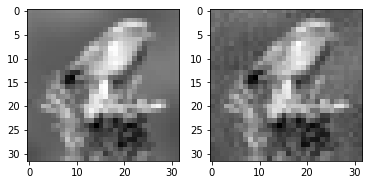

25  :  [0.9208859] 25
50  :  [0.92530197] 25
75  :  [0.9397063] 25
100  :  [0.9397063] 25
125  :  [0.9397063] 25
150  :  [0.9397063] 25
175  :  [0.94440234] 25
200  :  [0.94440234] 25
225  :  [0.9471195] 25
250  :  [0.9477408] 25
275  :  [0.9477408] 25
300  :  [0.9599501] 25
325  :  [0.9599501] 25
350  :  [0.9599501] 25
375  :  [0.96108115] 25
400  :  [0.96417564] 25
425  :  [0.96417564] 25
450  :  [0.96569324] 25
475  :  [0.96923226] 25
500  :  [0.96923226] 25
525  :  [0.96923226] 25
550  :  [0.9697635] 25
575  :  [0.9699172] 25
600  :  [0.97094274] 25
625  :  [0.97094274] 25
650  :  [0.97245145] 25
675  :  [0.972969] 25
700  :  [0.9733381] 25
725  :  [0.9737258] 25
750  :  [0.9742689] 25
775  :  [0.9742689] 25
800  :  [0.9742689] 25
825  :  [0.9742689] 25
850  :  [0.9745028] 25
875  :  [0.9748976] 25
900  :  [0.9748976] 25
925  :  [0.9752536] 25
950  :  [0.9752536] 25
975  :  [0.97539324] 25
1000  :  [0.9755696] 25
1025  :  [0.97558963] 25
1050  :  [0.9757135] 25
1075  :  [0.9757135]

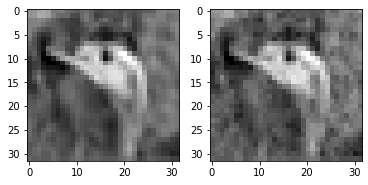

25  :  [0.69985956] 25
50  :  [0.70592654] 25
75  :  [0.8761703] 25
100  :  [0.8761703] 25
125  :  [0.8761703] 25
150  :  [0.8761703] 25
175  :  [0.8761703] 25
200  :  [0.8761703] 25
225  :  [0.8761703] 25
250  :  [0.8761703] 25
275  :  [0.8761703] 25
300  :  [0.91960967] 25
325  :  [0.91977096] 25
350  :  [0.91977096] 25
375  :  [0.91977096] 25
400  :  [0.91977096] 25
425  :  [0.92028916] 25
450  :  [0.92028916] 25
475  :  [0.92028916] 25
500  :  [0.92028916] 25
525  :  [0.92028916] 25
550  :  [0.92028916] 25
575  :  [0.92028916] 25
600  :  [0.9272006] 25
625  :  [0.9272006] 25
650  :  [0.927409] 25
675  :  [0.927409] 25
700  :  [0.92966104] 25
725  :  [0.92966104] 25
750  :  [0.9302509] 25
775  :  [0.93146557] 25
800  :  [0.9328319] 25
825  :  [0.9328319] 25
850  :  [0.935477] 25
875  :  [0.935477] 25
900  :  [0.93586946] 25
925  :  [0.93680954] 25
950  :  [0.93810725] 25
975  :  [0.9400566] 25
1000  :  [0.9400566] 25
1025  :  [0.9400566] 25
1050  :  [0.9407285] 25
1075  :  [0.940728

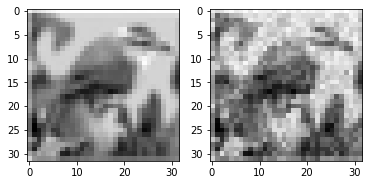

25  :  [0.6079691] 25
50  :  [0.7700626] 25
75  :  [0.78728217] 25
100  :  [0.7816405] 25
125  :  [0.7816405] 25
150  :  [0.7816405] 25
175  :  [0.7816405] 25
200  :  [0.7816405] 25
225  :  [0.7816405] 25
250  :  [0.7816405] 25
275  :  [0.80175054] 25
300  :  [0.8152553] 25
325  :  [0.8152553] 25
350  :  [0.8152553] 25
375  :  [0.8152553] 25
400  :  [0.8152553] 25
425  :  [0.8152553] 25
450  :  [0.8152553] 25
475  :  [0.8152553] 25
500  :  [0.8152553] 25
525  :  [0.8251633] 25
550  :  [0.8251633] 25
575  :  [0.8251633] 25
600  :  [0.83641684] 25
625  :  [0.8364248] 25
650  :  [0.8364248] 25
675  :  [0.8364248] 25
700  :  [0.8364248] 25
725  :  [0.8364248] 25
750  :  [0.8364248] 25
775  :  [0.8364248] 25
800  :  [0.8364248] 25
825  :  [0.8364248] 25
850  :  [0.8373997] 25
875  :  [0.8373816] 25
900  :  [0.8387383] 25
925  :  [0.8388028] 25
950  :  [0.8388028] 25
975  :  [0.845982] 25
1000  :  [0.845982] 25
1025  :  [0.845982] 25
1050  :  [0.8463211] 25
1075  :  [0.84635794] 25
1100  :  

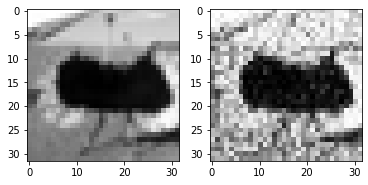

25  :  [0.41387784] 25
50  :  [0.50166225] 25
75  :  [0.5434677] 25
100  :  [0.6012759] 25
125  :  [0.60060704] 25
150  :  [0.60060704] 25
175  :  [0.60060704] 25
200  :  [0.60060704] 25
225  :  [0.60060704] 25
250  :  [0.60060704] 25
275  :  [0.60060704] 25
300  :  [0.6013841] 25
325  :  [0.60101664] 25
350  :  [0.6177697] 25
375  :  [0.6177697] 25
400  :  [0.6177697] 25
425  :  [0.6177697] 25
450  :  [0.6177697] 25
475  :  [0.6177697] 25
500  :  [0.6177697] 25
525  :  [0.6177697] 25
550  :  [0.6177697] 25
575  :  [0.6304728] 25
600  :  [0.630621] 25
625  :  [0.630621] 25
650  :  [0.630621] 25
675  :  [0.630621] 25
700  :  [0.630621] 25
725  :  [0.630621] 25
750  :  [0.6317959] 25
775  :  [0.6317959] 25
800  :  [0.6317959] 25
825  :  [0.63366705] 25
850  :  [0.637448] 25
875  :  [0.637448] 25
900  :  [0.6395298] 25
925  :  [0.64552534] 25
950  :  [0.64552534] 25
975  :  [0.64901924] 25
1000  :  [0.64901924] 25
1025  :  [0.64901924] 25
1050  :  [0.64901924] 25
1075  :  [0.651386] 25
11

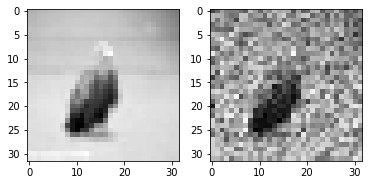

25  :  [0.70083773] 25
50  :  [0.70083773] 25
75  :  [0.67337465] 25
100  :  [0.7270151] 25
125  :  [0.740443] 25
150  :  [0.740443] 25
175  :  [0.740443] 25
200  :  [0.740443] 25
225  :  [0.740443] 25
250  :  [0.740443] 25
275  :  [0.740443] 25
300  :  [0.740443] 25
325  :  [0.740443] 25
350  :  [0.740443] 25
375  :  [0.740443] 25
400  :  [0.7418701] 25
425  :  [0.7582239] 25
450  :  [0.760577] 25
475  :  [0.760577] 25
500  :  [0.760577] 25
525  :  [0.760577] 25
550  :  [0.760577] 25
575  :  [0.760577] 25
600  :  [0.77673113] 25
625  :  [0.7755295] 25
650  :  [0.7755295] 25
675  :  [0.7755295] 25
700  :  [0.7755295] 25
725  :  [0.7755295] 25
750  :  [0.7755295] 25
775  :  [0.7755295] 25
800  :  [0.7755295] 25
825  :  [0.7755295] 25
850  :  [0.78259015] 25
875  :  [0.78710383] 25
900  :  [0.78710383] 25
925  :  [0.78710383] 25
950  :  [0.7966609] 25
975  :  [0.7990694] 25
1000  :  [0.8092218] 25
1025  :  [0.81560606] 25
1050  :  [0.8156044] 25
1075  :  [0.8156044] 25
1100  :  [0.815604

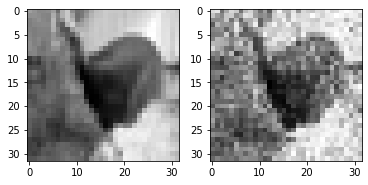

25  :  [0.88098454] 25
50  :  [0.88098454] 25
75  :  [0.88098454] 25
100  :  [0.88098454] 25
125  :  [0.88098454] 25
150  :  [0.88098454] 25
175  :  [0.88098454] 25
200  :  [0.88098454] 25
225  :  [0.88098454] 25
250  :  [0.88098454] 25
275  :  [0.88098454] 25
300  :  [0.89842176] 25
325  :  [0.9068666] 25
350  :  [0.9068591] 25
375  :  [0.9068591] 25
400  :  [0.91389704] 25
425  :  [0.91389704] 25
450  :  [0.9163575] 25
475  :  [0.9304359] 25
500  :  [0.9350097] 25
525  :  [0.9350097] 25
550  :  [0.9350097] 25
575  :  [0.9350097] 25
600  :  [0.9352919] 25
625  :  [0.94096434] 25
650  :  [0.94096434] 25
675  :  [0.94096434] 25
700  :  [0.94189656] 25
725  :  [0.94189656] 25
750  :  [0.94189656] 25
775  :  [0.94283646] 25
800  :  [0.9434023] 25
825  :  [0.94340545] 25
850  :  [0.94343686] 25
875  :  [0.94456017] 25
900  :  [0.94456017] 25
925  :  [0.9446294] 25
950  :  [0.94559747] 25
975  :  [0.946916] 25
1000  :  [0.9473835] 25
1025  :  [0.94741297] 25
1050  :  [0.9477496] 25
1075  : 

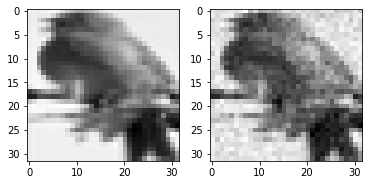

25  :  [0.65413654] 25
50  :  [0.7025543] 25
75  :  [0.7652801] 25
100  :  [0.76457655] 25
125  :  [0.7705271] 25
150  :  [0.7705271] 25
175  :  [0.7705271] 25
200  :  [0.7705271] 25
225  :  [0.7705271] 25
250  :  [0.7705271] 25
275  :  [0.7705271] 25
300  :  [0.77291393] 25
325  :  [0.77291393] 25
350  :  [0.77291393] 25
375  :  [0.77421904] 25
400  :  [0.7785797] 25
425  :  [0.7785797] 25
450  :  [0.7785797] 25
475  :  [0.7934967] 25
500  :  [0.7934967] 25
525  :  [0.7989714] 25
550  :  [0.80412877] 25
575  :  [0.8225512] 25
600  :  [0.8225512] 25
625  :  [0.8411839] 25
650  :  [0.8411839] 25
675  :  [0.8467585] 25
700  :  [0.84877247] 25
725  :  [0.85185665] 25
750  :  [0.85249305] 25
775  :  [0.8530655] 25
800  :  [0.85563064] 25
825  :  [0.8567135] 25
850  :  [0.8567135] 25
875  :  [0.85689676] 25
900  :  [0.85689676] 25
925  :  [0.85732555] 25
950  :  [0.85774994] 25
975  :  [0.85889685] 25
1000  :  [0.8592515] 25
1025  :  [0.8592515] 25
1050  :  [0.8603519] 25
1075  :  [0.861530

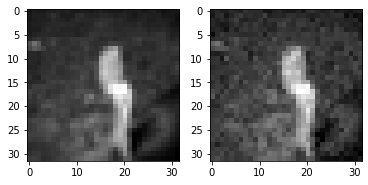

25  :  [0.93184304] 25
50  :  [0.9368472] 25
75  :  [0.95304763] 25
100  :  [0.9539034] 25
125  :  [0.9539034] 25
150  :  [0.9539034] 25
175  :  [0.9539034] 25
200  :  [0.9539034] 25
225  :  [0.95459545] 25
250  :  [0.95459545] 25
275  :  [0.96448374] 25
300  :  [0.96462977] 25
325  :  [0.96607137] 25
350  :  [0.9671563] 25
375  :  [0.96715295] 25
400  :  [0.9703533] 25
425  :  [0.9707022] 25
450  :  [0.97123575] 25
475  :  [0.97161925] 25
500  :  [0.9755146] 25
525  :  [0.9755146] 25
550  :  [0.9755146] 25
575  :  [0.9767703] 25
600  :  [0.9767703] 25
625  :  [0.9780727] 25
650  :  [0.97807294] 25
675  :  [0.97807294] 25
700  :  [0.97807294] 25
725  :  [0.97842515] 25
750  :  [0.97842515] 25
775  :  [0.97842515] 25
800  :  [0.97880256] 25
825  :  [0.979057] 25
850  :  [0.97944397] 25
Time:  104.25513911247253  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


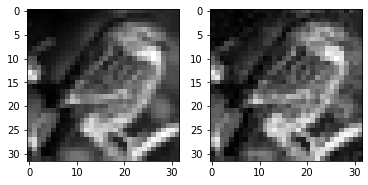

25  :  [0.65095574] 25
50  :  [0.87937385] 25
75  :  [0.88013744] 25
100  :  [0.88013744] 25
125  :  [0.8826457] 25
150  :  [0.88260937] 25
175  :  [0.88260937] 25
200  :  [0.88260937] 25
225  :  [0.88260937] 25
250  :  [0.88260937] 25
275  :  [0.88260937] 25
300  :  [0.88260937] 25
325  :  [0.88260937] 25
350  :  [0.88260937] 25
375  :  [0.88260937] 25
400  :  [0.8890109] 25
425  :  [0.89002055] 25
450  :  [0.8909136] 25
475  :  [0.9079064] 25
500  :  [0.9080392] 25
525  :  [0.9139372] 25
550  :  [0.91482335] 25
575  :  [0.91482335] 25
600  :  [0.9164845] 25
625  :  [0.9164845] 25
650  :  [0.9183903] 25
675  :  [0.9183903] 25
700  :  [0.9183903] 25
725  :  [0.91967237] 25
750  :  [0.9225173] 25
775  :  [0.92258954] 25
800  :  [0.92282784] 25
825  :  [0.9246291] 25
850  :  [0.9248817] 25
875  :  [0.9248817] 25
900  :  [0.92497814] 25
925  :  [0.92565644] 25
950  :  [0.92565644] 25
975  :  [0.92625105] 25
1000  :  [0.92625105] 25
1025  :  [0.92625105] 25
1050  :  [0.9263159] 25
1075  : 

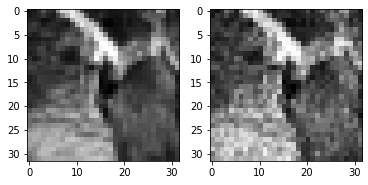

25  :  [0.4972394] 25
50  :  [0.50422764] 25
75  :  [0.562499] 25
100  :  [0.6656717] 25
125  :  [0.69301844] 25
150  :  [0.69301844] 25
175  :  [0.69301844] 25
200  :  [0.69301844] 25
225  :  [0.69301844] 25
250  :  [0.69301844] 25
275  :  [0.69301844] 25
300  :  [0.69301844] 25
325  :  [0.69301844] 25
350  :  [0.69301844] 25
375  :  [0.69585353] 25
400  :  [0.69585353] 25
425  :  [0.6990025] 25
450  :  [0.6990025] 25
475  :  [0.6990025] 25
500  :  [0.6990025] 25
525  :  [0.7034036] 25
550  :  [0.704147] 25
575  :  [0.704147] 25
600  :  [0.704147] 25
625  :  [0.7085139] 25
650  :  [0.71051943] 25
675  :  [0.71051943] 25
700  :  [0.7120533] 25
725  :  [0.71360964] 25
750  :  [0.71579945] 25
775  :  [0.7172573] 25
800  :  [0.7173928] 25
825  :  [0.71922415] 25
850  :  [0.71937144] 25
875  :  [0.72098285] 25
900  :  [0.723451] 25
Time:  107.67175602912903  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [0]


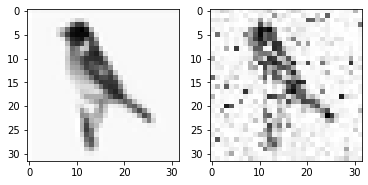

25  :  [0.6628934] 25
50  :  [0.6628934] 25
75  :  [0.5308648] 25
100  :  [0.6690334] 25
125  :  [0.61082774] 25
150  :  [0.61082774] 25
175  :  [0.61082774] 25
200  :  [0.61082774] 25
225  :  [0.61082774] 25
250  :  [0.61082774] 25
275  :  [0.61082774] 25
300  :  [0.61082774] 25
325  :  [0.61082774] 25
350  :  [0.61082774] 25
375  :  [0.61082774] 25
400  :  [0.61082774] 25
425  :  [0.61082774] 25
450  :  [0.61082774] 25
475  :  [0.61082774] 25
500  :  [0.61082774] 25
525  :  [0.61082774] 25
550  :  [0.61082774] 25
575  :  [0.61082774] 25
600  :  [0.64212686] 25
625  :  [0.64212686] 25
650  :  [0.64212686] 25
675  :  [0.64212686] 25
700  :  [0.65498924] 25
725  :  [0.6599697] 25
750  :  [0.6599697] 25
775  :  [0.6599697] 25
800  :  [0.6599697] 25
825  :  [0.6599697] 25
850  :  [0.6599697] 25
875  :  [0.6599697] 25
900  :  [0.66558486] 25
925  :  [0.67739415] 25
950  :  [0.67725205] 25
975  :  [0.67725205] 25
1000  :  [0.67725205] 25
1025  :  [0.67725205] 25
1050  :  [0.67725205] 25
107

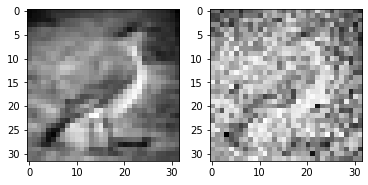

25  :  [0.53758836] 25
50  :  [0.5551326] 25
75  :  [0.5026106] 25
100  :  [0.5026106] 25
125  :  [0.5372427] 25
150  :  [0.53771734] 25
175  :  [0.53771734] 25
200  :  [0.53771734] 25
225  :  [0.53771734] 25
250  :  [0.5560048] 25
275  :  [0.5572305] 25
300  :  [0.5738175] 25
325  :  [0.5738175] 25
350  :  [0.57465506] 25
375  :  [0.584909] 25
400  :  [0.59211373] 25
425  :  [0.58976275] 25
450  :  [0.59308183] 25
475  :  [0.605414] 25
500  :  [0.6057669] 25
525  :  [0.6057669] 25
550  :  [0.6152261] 25
575  :  [0.6153039] 25
600  :  [0.617577] 25
625  :  [0.6198401] 25
650  :  [0.6198401] 25
675  :  [0.62292475] 25
700  :  [0.62398016] 25
725  :  [0.6248437] 25
750  :  [0.6267046] 25
775  :  [0.62690055] 25
800  :  [0.628255] 25
825  :  [0.628255] 25
850  :  [0.6282866] 25
875  :  [0.62879205] 25
900  :  [0.62903607] 25
925  :  [0.6292334] 25
950  :  [0.6294551] 25
975  :  [0.6295528] 25
1000  :  [0.62957406] 25
1025  :  [0.62979746] 25
1050  :  [0.62998027] 25
1075  :  [0.6299947] 2

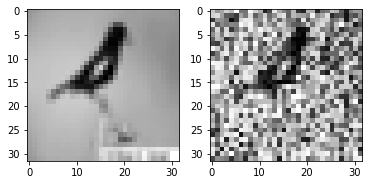

25  :  [0.95151913] 25
50  :  [0.95151913] 25
75  :  [0.96142346] 25
100  :  [0.96295613] 25
125  :  [0.96295613] 25
150  :  [0.9647941] 25
175  :  [0.9677339] 25
200  :  [0.9677339] 25
225  :  [0.9677339] 25
250  :  [0.9682505] 25
275  :  [0.97051334] 25
300  :  [0.97843593] 25
325  :  [0.97843593] 25
350  :  [0.9784361] 25
375  :  [0.9801228] 25
400  :  [0.9801228] 25
425  :  [0.9801228] 25
450  :  [0.98064303] 25
475  :  [0.9813111] 25
500  :  [0.9813111] 25
525  :  [0.982105] 25
550  :  [0.982105] 25
575  :  [0.982105] 25
600  :  [0.98226047] 25
625  :  [0.98226047] 25
650  :  [0.98298633] 25
675  :  [0.98298633] 25
700  :  [0.9834099] 25
725  :  [0.9837115] 25
750  :  [0.9837115] 25
775  :  [0.98390406] 25
800  :  [0.98390406] 25
Time:  96.96127319335938  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


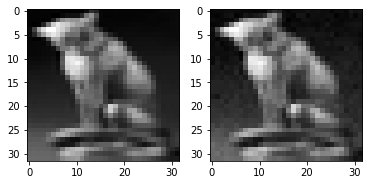

25  :  [0.80745494] 25
50  :  [0.82684845] 25
75  :  [0.84263337] 25
100  :  [0.84348947] 25
125  :  [0.84679705] 25
150  :  [0.8468472] 25
175  :  [0.8585297] 25
200  :  [0.8582771] 25
225  :  [0.8582771] 25
250  :  [0.8582771] 25
275  :  [0.8582771] 25
300  :  [0.8582771] 25
325  :  [0.8582771] 25
350  :  [0.8582771] 25
375  :  [0.8582771] 25
400  :  [0.8582771] 25
425  :  [0.8582771] 25
450  :  [0.8582771] 25
475  :  [0.8582771] 25
500  :  [0.8582771] 25
525  :  [0.8582771] 25
550  :  [0.8582771] 25
575  :  [0.8582771] 25
600  :  [0.8582771] 25
625  :  [0.8582771] 25
650  :  [0.8582771] 25
675  :  [0.8582771] 25
700  :  [0.8582771] 25
725  :  [0.8582771] 25
750  :  [0.8582771] 25
775  :  [0.8582771] 25
800  :  [0.8582771] 25
825  :  [0.8582771] 25
850  :  [0.8582771] 25
875  :  [0.8582771] 25
900  :  [0.8582771] 25
925  :  [0.8582771] 25
950  :  [0.8582771] 25
Time:  114.02998638153076  seconds
Original class:  3
Prediction for normal image:  [0]
Prediction for adversarial image:  [

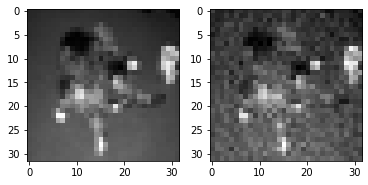

25  :  [0.77920246] 25
50  :  [0.77920246] 25
75  :  [0.9079019] 25
100  :  [0.92618763] 25
125  :  [0.92680824] 25
150  :  [0.92680824] 25
175  :  [0.92680824] 25
200  :  [0.92680824] 25
225  :  [0.92680824] 25
250  :  [0.92680824] 25
275  :  [0.92680824] 25
300  :  [0.92778087] 25
325  :  [0.9372003] 25
350  :  [0.94106257] 25
375  :  [0.9414731] 25
400  :  [0.9414925] 25
425  :  [0.94203544] 25
450  :  [0.94203544] 25
475  :  [0.9465473] 25
500  :  [0.9465473] 25
525  :  [0.9465473] 25
550  :  [0.9470409] 25
575  :  [0.9484888] 25
600  :  [0.9487443] 25
625  :  [0.9526323] 25
650  :  [0.9526371] 25
675  :  [0.9526371] 25
700  :  [0.95301527] 25
725  :  [0.9547205] 25
750  :  [0.9547205] 25
775  :  [0.95567775] 25
800  :  [0.9585572] 25
825  :  [0.9585764] 25
850  :  [0.9585764] 25
875  :  [0.9585764] 25
Time:  105.27034521102905  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [6]


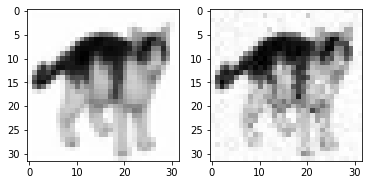

25  :  [0.8976224] 25
50  :  [0.8976224] 25
75  :  [0.8976224] 25
100  :  [0.8976224] 25
125  :  [0.8976224] 25
150  :  [0.8976224] 25
175  :  [0.8976224] 25
200  :  [0.8976224] 25
225  :  [0.8976224] 25
250  :  [0.8976224] 25
275  :  [0.8976224] 25
300  :  [0.8976224] 25
325  :  [0.8976224] 25
350  :  [0.8976224] 25
375  :  [0.9068064] 25
400  :  [0.9067875] 25
425  :  [0.9205531] 25
450  :  [0.9205531] 25
475  :  [0.9400255] 25
500  :  [0.9400255] 25
525  :  [0.9400255] 25
550  :  [0.9400255] 25
575  :  [0.9400255] 25
600  :  [0.9400255] 25
625  :  [0.9400255] 25
650  :  [0.9400255] 25
675  :  [0.9400255] 25
700  :  [0.9450078] 25
725  :  [0.9450078] 25
750  :  [0.9450078] 25
775  :  [0.9516989] 25
800  :  [0.9521359] 25
825  :  [0.9544675] 25
850  :  [0.9544675] 25
875  :  [0.9546143] 25
900  :  [0.9549079] 25
925  :  [0.9549079] 25
950  :  [0.9562351] 25
975  :  [0.95705414] 25
1000  :  [0.9582099] 25
1025  :  [0.9582099] 25
1050  :  [0.9582099] 25
1075  :  [0.9582099] 25
1100  :  

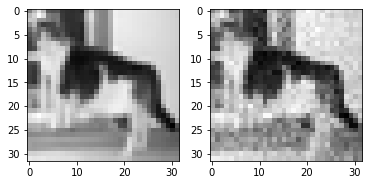

25  :  [0.961635] 25
50  :  [0.961635] 25
75  :  [0.96254146] 25
100  :  [0.9625851] 25
125  :  [0.9625851] 25
150  :  [0.97066396] 25
175  :  [0.97066396] 25
200  :  [0.97066396] 25
225  :  [0.97066396] 25
250  :  [0.97229934] 25
275  :  [0.97229934] 25
300  :  [0.9757242] 25
325  :  [0.97965705] 25
350  :  [0.97965705] 25
375  :  [0.9811561] 25
400  :  [0.9833186] 25
425  :  [0.9833186] 25
450  :  [0.9833186] 25
475  :  [0.9848139] 25
500  :  [0.9848139] 25
525  :  [0.9848139] 25
550  :  [0.9848139] 25
575  :  [0.9848139] 25
600  :  [0.9852177] 25
625  :  [0.98525953] 25
650  :  [0.98542976] 25
675  :  [0.98542976] 25
700  :  [0.98548293] 25
725  :  [0.98588765] 25
750  :  [0.9862687] 25
775  :  [0.9862796] 25
800  :  [0.9863867] 25
Time:  97.92529630661011  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


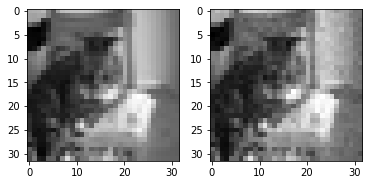

25  :  [0.8985617] 25
50  :  [0.8985617] 25
75  :  [0.8985617] 25
100  :  [0.8985617] 25
125  :  [0.8985617] 25
150  :  [0.90363336] 25
175  :  [0.91188717] 25
200  :  [0.91188717] 25
225  :  [0.9154172] 25
250  :  [0.9154172] 25
275  :  [0.91780496] 25
300  :  [0.91780496] 25
325  :  [0.9225166] 25
350  :  [0.9225166] 25
375  :  [0.9225166] 25
400  :  [0.92511797] 25
425  :  [0.92511797] 25
450  :  [0.9292743] 25
475  :  [0.9292743] 25
500  :  [0.9292743] 25
525  :  [0.9365627] 25
550  :  [0.9384612] 25
575  :  [0.9455529] 25
600  :  [0.9528002] 25
625  :  [0.9528002] 25
650  :  [0.9528002] 25
675  :  [0.95506036] 25
700  :  [0.95506036] 25
725  :  [0.95506036] 25
750  :  [0.95506036] 25
775  :  [0.95785093] 25
800  :  [0.95785093] 25
Time:  95.01735520362854  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


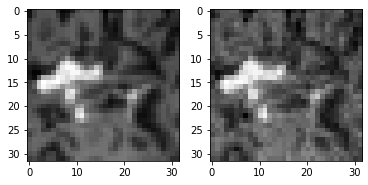

25  :  [0.7114707] 25
50  :  [0.7114707] 25
75  :  [0.7084645] 25
100  :  [0.72004145] 25
125  :  [0.72004145] 25
150  :  [0.76339805] 25
175  :  [0.78442806] 25
200  :  [0.78442806] 25
225  :  [0.78442806] 25
250  :  [0.78442806] 25
275  :  [0.78442806] 25
300  :  [0.78442806] 25
325  :  [0.78442806] 25
350  :  [0.78442806] 25
375  :  [0.79847693] 25
400  :  [0.7986505] 25
425  :  [0.7986505] 25
450  :  [0.7986505] 25
475  :  [0.7986505] 25
500  :  [0.81885654] 25
525  :  [0.81888974] 25
550  :  [0.81888974] 25
575  :  [0.81888974] 25
600  :  [0.81888974] 25
625  :  [0.81888974] 25
650  :  [0.81888974] 25
675  :  [0.81888974] 25
700  :  [0.81888974] 25
725  :  [0.81888974] 25
750  :  [0.81888974] 25
775  :  [0.83957577] 25
800  :  [0.83957577] 25
825  :  [0.8546058] 25
850  :  [0.8546058] 25
875  :  [0.8546058] 25
900  :  [0.8546058] 25
925  :  [0.8546058] 25
950  :  [0.8546058] 25
975  :  [0.8674585] 25
1000  :  [0.8674585] 25
1025  :  [0.8674585] 25
1050  :  [0.8674585] 25
1075  :  

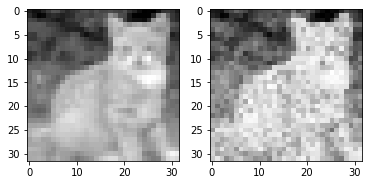

25  :  [0.8705611] 25
50  :  [0.8705611] 25
75  :  [0.8705611] 25
100  :  [0.8705611] 25
125  :  [0.8705611] 25
150  :  [0.8705611] 25
175  :  [0.8705611] 25
200  :  [0.87496257] 25
225  :  [0.88268244] 25
250  :  [0.88272685] 25
275  :  [0.88272685] 25
300  :  [0.88272685] 25
325  :  [0.88272685] 25
350  :  [0.88272685] 25
375  :  [0.884163] 25
400  :  [0.88791823] 25
425  :  [0.88791823] 25
450  :  [0.89098024] 25
475  :  [0.89870787] 25
500  :  [0.90522003] 25
525  :  [0.90522003] 25
550  :  [0.91168267] 25
575  :  [0.91168267] 25
600  :  [0.91168267] 25
625  :  [0.91168267] 25
650  :  [0.91458076] 25
675  :  [0.91543305] 25
700  :  [0.91543305] 25
725  :  [0.91666025] 25
750  :  [0.9178153] 25
775  :  [0.9179145] 25
800  :  [0.9184909] 25
Time:  93.99357962608337  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


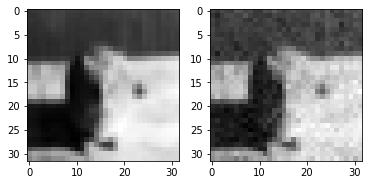

25  :  [0.6343374] 25
50  :  [0.6343374] 25
75  :  [0.65701795] 25
100  :  [0.672063] 25
125  :  [0.65701795] 25
150  :  [0.67517966] 25
175  :  [0.6844299] 25
200  :  [0.6844299] 25
225  :  [0.6859607] 25
250  :  [0.6882692] 25
275  :  [0.6882692] 25
300  :  [0.6882692] 25
325  :  [0.69314384] 25
350  :  [0.69848025] 25
375  :  [0.69848025] 25
400  :  [0.69848025] 25
425  :  [0.69848025] 25
450  :  [0.69848025] 25
475  :  [0.69848025] 25
500  :  [0.69848025] 25
525  :  [0.69848025] 25
550  :  [0.69848025] 25
575  :  [0.69848025] 25
600  :  [0.69848025] 25
625  :  [0.69848025] 25
650  :  [0.69848025] 25
675  :  [0.69848025] 25
700  :  [0.69848025] 25
725  :  [0.69848025] 25
750  :  [0.69848025] 25
775  :  [0.69848025] 25
800  :  [0.69848025] 25
825  :  [0.69848025] 25
850  :  [0.69848025] 25
875  :  [0.69848025] 25
900  :  [0.69848025] 25
925  :  [0.69848025] 25
Time:  107.35162329673767  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2

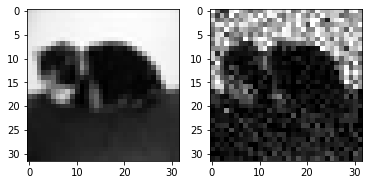

25  :  [0.9041587] 25
50  :  [0.9041587] 25
75  :  [0.9041587] 25
100  :  [0.9172831] 25
125  :  [0.9172831] 25
150  :  [0.9365841] 25
175  :  [0.9365841] 25
200  :  [0.9365841] 25
225  :  [0.9365841] 25
250  :  [0.9365841] 25
275  :  [0.9365841] 25
300  :  [0.94257724] 25
325  :  [0.94257724] 25
350  :  [0.94257724] 25
375  :  [0.94257724] 25
400  :  [0.94257724] 25
425  :  [0.94560647] 25
450  :  [0.94560647] 25
475  :  [0.9492049] 25
500  :  [0.9578173] 25
525  :  [0.96103597] 25
550  :  [0.96103597] 25
575  :  [0.96103597] 25
600  :  [0.96103597] 25
625  :  [0.9622683] 25
650  :  [0.9641601] 25
675  :  [0.9641601] 25
700  :  [0.9641601] 25
725  :  [0.96494097] 25
750  :  [0.96675426] 25
775  :  [0.96721447] 25
800  :  [0.9675878] 25
825  :  [0.9675878] 25
850  :  [0.9678434] 25
875  :  [0.96859473] 25
900  :  [0.96930206] 25
925  :  [0.96930206] 25
Time:  112.45275020599365  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


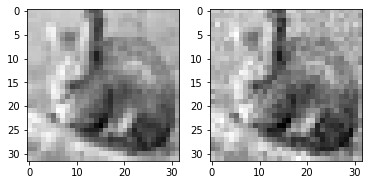

25  :  [0.79076016] 25
50  :  [0.85241175] 25
75  :  [0.8628416] 25
100  :  [0.8628416] 25
125  :  [0.8628416] 25
150  :  [0.90104735] 25
175  :  [0.90104735] 25
200  :  [0.90104735] 25
225  :  [0.90104735] 25
250  :  [0.90104735] 25
275  :  [0.90104735] 25
300  :  [0.90168643] 25
325  :  [0.90168643] 25
350  :  [0.90168643] 25
375  :  [0.9114654] 25
400  :  [0.9114864] 25
425  :  [0.9114864] 25
450  :  [0.91300803] 25
475  :  [0.91526544] 25
500  :  [0.9180653] 25
525  :  [0.9183265] 25
550  :  [0.9192842] 25
575  :  [0.9204292] 25
600  :  [0.9204292] 25
625  :  [0.9215883] 25
650  :  [0.9215828] 25
675  :  [0.92332816] 25
700  :  [0.9234879] 25
725  :  [0.92468405] 25
750  :  [0.92511314] 25
775  :  [0.9264195] 25
800  :  [0.9264195] 25
825  :  [0.9264195] 25
850  :  [0.92673886] 25
875  :  [0.92673886] 25
900  :  [0.92703104] 25
925  :  [0.92703104] 25
Time:  114.67087578773499  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


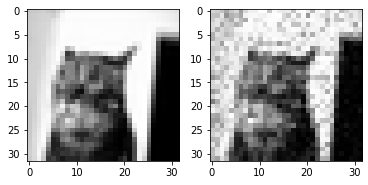

25  :  [0.95861614] 25
50  :  [0.95861614] 25
75  :  [0.95861614] 25
100  :  [0.95861614] 25
125  :  [0.95861614] 25
150  :  [0.95861614] 25
175  :  [0.96470743] 25
200  :  [0.96470743] 25
225  :  [0.96470743] 25
250  :  [0.96470743] 25
275  :  [0.965894] 25
300  :  [0.9755073] 25
325  :  [0.97586787] 25
350  :  [0.97586787] 25
375  :  [0.97586787] 25
400  :  [0.97586787] 25
425  :  [0.9830295] 25
450  :  [0.9847083] 25
475  :  [0.9847083] 25
500  :  [0.9847083] 25
525  :  [0.9847083] 25
550  :  [0.9847083] 25
575  :  [0.98505074] 25
600  :  [0.98505074] 25
625  :  [0.9868623] 25
650  :  [0.9875453] 25
675  :  [0.9875453] 25
700  :  [0.98764175] 25
725  :  [0.9877418] 25
750  :  [0.98782647] 25
775  :  [0.98806906] 25
800  :  [0.9880767] 25
Time:  96.85613226890564  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


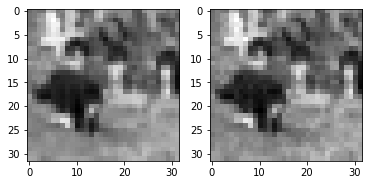

25  :  [0.95684576] 25
50  :  [0.9724877] 25
75  :  [0.9724859] 25
100  :  [0.9724859] 25
125  :  [0.97301024] 25
150  :  [0.97301024] 25
175  :  [0.97509694] 25
200  :  [0.97509694] 25
225  :  [0.97509694] 25
250  :  [0.97509694] 25
275  :  [0.97509694] 25
300  :  [0.97509694] 25
325  :  [0.97509694] 25
350  :  [0.97509694] 25
375  :  [0.97509694] 25
400  :  [0.97731745] 25
425  :  [0.97861665] 25
450  :  [0.9787822] 25
475  :  [0.9804586] 25
500  :  [0.9804586] 25
525  :  [0.9804586] 25
550  :  [0.981421] 25
575  :  [0.98266566] 25
600  :  [0.9853065] 25
625  :  [0.9853065] 25
650  :  [0.9853065] 25
675  :  [0.9857209] 25
700  :  [0.9857209] 25
725  :  [0.9865787] 25
750  :  [0.9865787] 25
775  :  [0.9865787] 25
800  :  [0.9865787] 25
825  :  [0.9867259] 25
Time:  100.03363347053528  seconds
Original class:  3
Prediction for normal image:  [5]
Prediction for adversarial image:  [6]


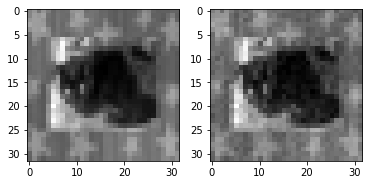

25  :  [0.36666757] 25
50  :  [0.49617916] 25
75  :  [0.7895657] 25
100  :  [0.83992875] 25
125  :  [0.83992875] 25
150  :  [0.83992875] 25
175  :  [0.83992875] 25
200  :  [0.8764522] 25
225  :  [0.87657124] 25
250  :  [0.87657124] 25
275  :  [0.87657124] 25
300  :  [0.87657124] 25
325  :  [0.87657124] 25
350  :  [0.87657124] 25
375  :  [0.88595366] 25
400  :  [0.88595366] 25
425  :  [0.88595366] 25
450  :  [0.88595366] 25
475  :  [0.88595366] 25
500  :  [0.8912636] 25
525  :  [0.8912636] 25
550  :  [0.8919054] 25
575  :  [0.8919054] 25
600  :  [0.8923322] 25
625  :  [0.89253724] 25
650  :  [0.9010181] 25
675  :  [0.9010181] 25
700  :  [0.9011114] 25
725  :  [0.9028679] 25
750  :  [0.90318716] 25
775  :  [0.90318716] 25
800  :  [0.904464] 25
825  :  [0.9060521] 25
850  :  [0.9060521] 25
875  :  [0.9064671] 25
900  :  [0.9074267] 25
925  :  [0.9088162] 25
950  :  [0.9090146] 25
975  :  [0.90964305] 25
Time:  120.98116946220398  seconds
Original class:  4
Prediction for normal image:  [4

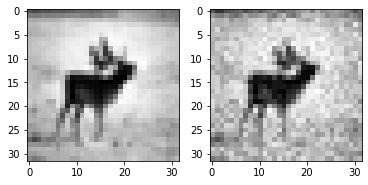

25  :  [0.7460271] 25
50  :  [0.79338825] 25
75  :  [0.6240783] 25
100  :  [0.74530274] 25
125  :  [0.77392405] 25
150  :  [0.8267075] 25
175  :  [0.8267075] 25
200  :  [0.8267075] 25
225  :  [0.8267075] 25
250  :  [0.8267075] 25
275  :  [0.8267075] 25
300  :  [0.8267075] 25
325  :  [0.8267075] 25
350  :  [0.8267075] 25
375  :  [0.8267075] 25
400  :  [0.8267075] 25
425  :  [0.8267075] 25
450  :  [0.8267075] 25
475  :  [0.8267075] 25
500  :  [0.8267075] 25
525  :  [0.8398243] 25
550  :  [0.8398243] 25
575  :  [0.84273] 25
600  :  [0.852697] 25
625  :  [0.852697] 25
650  :  [0.852697] 25
675  :  [0.852697] 25
700  :  [0.852697] 25
725  :  [0.85329425] 25
750  :  [0.8584591] 25
775  :  [0.8665476] 25
800  :  [0.8811314] 25
825  :  [0.8811234] 25
850  :  [0.88513684] 25
875  :  [0.88513684] 25
900  :  [0.89011574] 25
925  :  [0.89011574] 25
950  :  [0.89011574] 25
975  :  [0.89022624] 25
1000  :  [0.89035994] 25
1025  :  [0.89108753] 25
1050  :  [0.8943995] 25
1075  :  [0.89477795] 25
1100

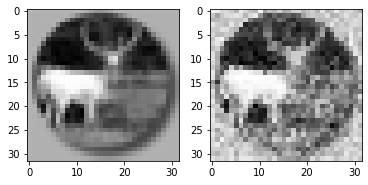

25  :  [0.9234446] 25
50  :  [0.9234446] 25
75  :  [0.9239296] 25
100  :  [0.9239296] 25
125  :  [0.9239296] 25
150  :  [0.9369077] 25
175  :  [0.9368887] 25
200  :  [0.9368887] 25
225  :  [0.9369585] 25
250  :  [0.9369585] 25
275  :  [0.9461707] 25
300  :  [0.9476753] 25
325  :  [0.9486096] 25
350  :  [0.9572135] 25
375  :  [0.9572135] 25
400  :  [0.9620491] 25
425  :  [0.9620491] 25
450  :  [0.9620491] 25
475  :  [0.9620491] 25
500  :  [0.96513295] 25
525  :  [0.9734971] 25
550  :  [0.9734971] 25
575  :  [0.97448087] 25
600  :  [0.9751856] 25
625  :  [0.9751856] 25
650  :  [0.9751856] 25
675  :  [0.9751856] 25
700  :  [0.97526556] 25
725  :  [0.9759308] 25
750  :  [0.9761306] 25
775  :  [0.9761558] 25
800  :  [0.9761558] 25
825  :  [0.97641945] 25
850  :  [0.9765427] 25
875  :  [0.9765427] 25
900  :  [0.9765731] 25
925  :  [0.97681105] 25
Time:  118.03434205055237  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


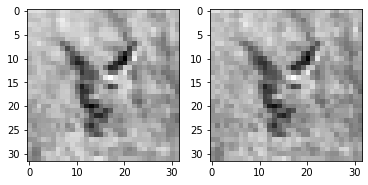

25  :  [0.9309488] 25
50  :  [0.93542546] 25
75  :  [0.9483335] 25
100  :  [0.9481827] 25
125  :  [0.9481827] 25
150  :  [0.9481827] 25
175  :  [0.94918495] 25
200  :  [0.94918495] 25
225  :  [0.94918495] 25
250  :  [0.95398504] 25
275  :  [0.95980275] 25
300  :  [0.9597121] 25
325  :  [0.9597121] 25
350  :  [0.9597121] 25
375  :  [0.9597121] 25
400  :  [0.9597121] 25
425  :  [0.9597121] 25
450  :  [0.961752] 25
475  :  [0.9615513] 25
500  :  [0.9615513] 25
525  :  [0.9615513] 25
550  :  [0.9615513] 25
575  :  [0.9615513] 25
600  :  [0.9682566] 25
625  :  [0.97217906] 25
650  :  [0.97217906] 25
675  :  [0.97217906] 25
700  :  [0.97217906] 25
725  :  [0.97217906] 25
750  :  [0.97217906] 25
775  :  [0.97217906] 25
800  :  [0.97221804] 25
825  :  [0.97265255] 25
850  :  [0.97265244] 25
Time:  104.41484761238098  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


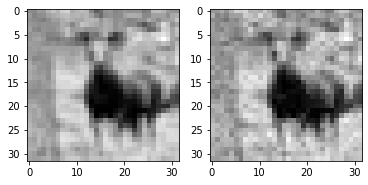

25  :  [0.7888944] 25
50  :  [0.7994957] 25
75  :  [0.8021003] 25
100  :  [0.81484556] 25
125  :  [0.82639277] 25
150  :  [0.82639277] 25
175  :  [0.8328874] 25
200  :  [0.8526032] 25
225  :  [0.8619665] 25
250  :  [0.8619665] 25
275  :  [0.8648758] 25
300  :  [0.8648758] 25
325  :  [0.88188493] 25
350  :  [0.88424313] 25
375  :  [0.88424313] 25
400  :  [0.88661444] 25
425  :  [0.89602244] 25
450  :  [0.89602244] 25
475  :  [0.89602244] 25
500  :  [0.89602244] 25
525  :  [0.8991879] 25
550  :  [0.91312253] 25
575  :  [0.9158635] 25
600  :  [0.91683424] 25
625  :  [0.91683424] 25
650  :  [0.9225126] 25
675  :  [0.9231544] 25
700  :  [0.92497665] 25
725  :  [0.92497665] 25
750  :  [0.9270357] 25
775  :  [0.9279739] 25
800  :  [0.9329916] 25
825  :  [0.9329916] 25
850  :  [0.93404245] 25
875  :  [0.9346659] 25
900  :  [0.9346659] 25
925  :  [0.9346659] 25
950  :  [0.93599457] 25
975  :  [0.9369373] 25
1000  :  [0.9369373] 25
1025  :  [0.938289] 25
1050  :  [0.9386817] 25
1075  :  [0.93908

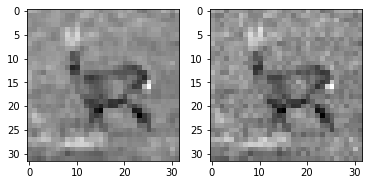

25  :  [0.8579943] 25
50  :  [0.8579943] 25
75  :  [0.8579943] 25
100  :  [0.86739695] 25
125  :  [0.87301826] 25
150  :  [0.8878161] 25
175  :  [0.8878161] 25
200  :  [0.8897181] 25
225  :  [0.8897181] 25
250  :  [0.8897181] 25
275  :  [0.9023878] 25
300  :  [0.9023878] 25
325  :  [0.9148475] 25
350  :  [0.9331264] 25
375  :  [0.9331264] 25
400  :  [0.9333234] 25
425  :  [0.9333234] 25
450  :  [0.9333234] 25
475  :  [0.9333234] 25
500  :  [0.9359821] 25
525  :  [0.936956] 25
550  :  [0.936956] 25
575  :  [0.93990743] 25
600  :  [0.9403746] 25
625  :  [0.9480969] 25
650  :  [0.9480969] 25
675  :  [0.9496982] 25
700  :  [0.9513998] 25
725  :  [0.9513998] 25
750  :  [0.9513998] 25
775  :  [0.9523859] 25
800  :  [0.9523859] 25
825  :  [0.9524067] 25
850  :  [0.9524635] 25
875  :  [0.9524635] 25
900  :  [0.95284235] 25
925  :  [0.9529172] 25
950  :  [0.9529172] 25
975  :  [0.95309293] 25
1000  :  [0.95316255] 25
1025  :  [0.95328677] 25
1050  :  [0.95328677] 25
1075  :  [0.95343983] 25
110

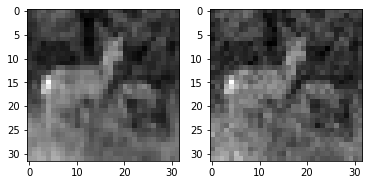

25  :  [0.8989065] 25
50  :  [0.9208988] 25
75  :  [0.9208988] 25
100  :  [0.9208988] 25
125  :  [0.9208988] 25
150  :  [0.92791593] 25
175  :  [0.92997944] 25
200  :  [0.930212] 25
225  :  [0.93181765] 25
250  :  [0.9358852] 25
275  :  [0.9395472] 25
300  :  [0.93953407] 25
325  :  [0.93953407] 25
350  :  [0.93953407] 25
375  :  [0.9401784] 25
400  :  [0.9454731] 25
425  :  [0.94716585] 25
450  :  [0.94994164] 25
475  :  [0.94994164] 25
500  :  [0.9517801] 25
525  :  [0.95312846] 25
550  :  [0.9581904] 25
575  :  [0.9581904] 25
600  :  [0.9581904] 25
625  :  [0.9581904] 25
650  :  [0.9638498] 25
675  :  [0.9638498] 25
700  :  [0.9665295] 25
725  :  [0.9669825] 25
750  :  [0.9669825] 25
775  :  [0.9671886] 25
800  :  [0.9674722] 25
825  :  [0.96815515] 25
Time:  101.68619108200073  seconds
Original class:  4
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


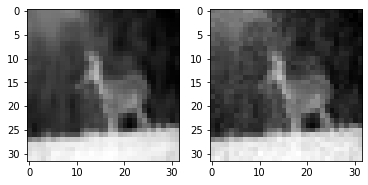

25  :  [0.34351566] 25
50  :  [0.3883563] 25
75  :  [0.7627782] 25
100  :  [0.7780895] 25
125  :  [0.7780895] 25
150  :  [0.7780895] 25
175  :  [0.7780895] 25
200  :  [0.7780895] 25
225  :  [0.7780895] 25
250  :  [0.7780895] 25
275  :  [0.7935134] 25
300  :  [0.7935134] 25
325  :  [0.80054796] 25
350  :  [0.80054796] 25
375  :  [0.8060479] 25
400  :  [0.8060479] 25
425  :  [0.8060479] 25
450  :  [0.811087] 25
475  :  [0.8111088] 25
500  :  [0.8248886] 25
525  :  [0.833189] 25
550  :  [0.8406997] 25
575  :  [0.84483725] 25
600  :  [0.84483725] 25
625  :  [0.84483725] 25
650  :  [0.8457701] 25
675  :  [0.84582305] 25
700  :  [0.85080045] 25
725  :  [0.8536951] 25
750  :  [0.8569586] 25
775  :  [0.8569586] 25
800  :  [0.8578025] 25
825  :  [0.858067] 25
850  :  [0.8587497] 25
875  :  [0.8587497] 25
900  :  [0.8595345] 25
925  :  [0.85962915] 25
950  :  [0.8601961] 25
975  :  [0.8601961] 25
1000  :  [0.86048865] 25
1025  :  [0.86048865] 25
1050  :  [0.86048865] 25
1075  :  [0.8605447] 25
1

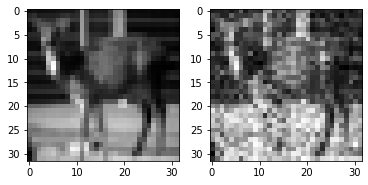

25  :  [0.8617033] 25
50  :  [0.8617033] 25
75  :  [0.87146676] 25
100  :  [0.87146676] 25
125  :  [0.8972019] 25
150  :  [0.89717484] 25
175  :  [0.89717484] 25
200  :  [0.89717484] 25
225  :  [0.89717484] 25
250  :  [0.89793813] 25
275  :  [0.89793813] 25
300  :  [0.90534854] 25
325  :  [0.90564126] 25
350  :  [0.90564126] 25
375  :  [0.90564126] 25
400  :  [0.90564126] 25
425  :  [0.90564126] 25
450  :  [0.906495] 25
475  :  [0.9217578] 25
500  :  [0.9217578] 25
525  :  [0.92512536] 25
550  :  [0.92512536] 25
575  :  [0.9262117] 25
600  :  [0.9262117] 25
625  :  [0.92766446] 25
650  :  [0.92766446] 25
675  :  [0.9289046] 25
700  :  [0.9302487] 25
725  :  [0.9332806] 25
750  :  [0.9332806] 25
775  :  [0.9367966] 25
800  :  [0.9413324] 25
825  :  [0.9413324] 25
850  :  [0.94272023] 25
875  :  [0.94272023] 25
900  :  [0.94416565] 25
925  :  [0.94666344] 25
950  :  [0.94666344] 25
975  :  [0.947963] 25
1000  :  [0.94879353] 25
1025  :  [0.9496608] 25
1050  :  [0.94974196] 25
1075  :  [0

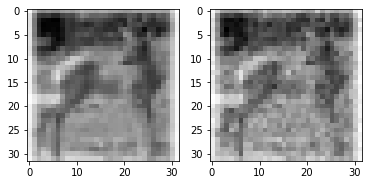

25  :  [0.8348627] 25
50  :  [0.8431295] 25
75  :  [0.85843015] 25
100  :  [0.85843015] 25
125  :  [0.86581767] 25
150  :  [0.8664451] 25
175  :  [0.8664451] 25
200  :  [0.8664451] 25
225  :  [0.8664451] 25
250  :  [0.8780753] 25
275  :  [0.8778453] 25
300  :  [0.8778453] 25
325  :  [0.8781286] 25
350  :  [0.8782775] 25
375  :  [0.8903104] 25
400  :  [0.8903104] 25
425  :  [0.89150596] 25
450  :  [0.894899] 25
475  :  [0.8961749] 25
500  :  [0.89618874] 25
525  :  [0.90302014] 25
550  :  [0.90302014] 25
575  :  [0.91081136] 25
600  :  [0.91081136] 25
625  :  [0.9194059] 25
650  :  [0.9194059] 25
675  :  [0.9194059] 25
700  :  [0.9194059] 25
725  :  [0.9245821] 25
750  :  [0.9245821] 25
775  :  [0.9245821] 25
800  :  [0.9245821] 25
825  :  [0.9290478] 25
850  :  [0.9332875] 25
875  :  [0.9332875] 25
900  :  [0.9332875] 25
925  :  [0.9332875] 25
950  :  [0.9332875] 25
975  :  [0.9332875] 25
1000  :  [0.9332875] 25
1025  :  [0.9332875] 25
1050  :  [0.9332875] 25
1075  :  [0.93506294] 25
1

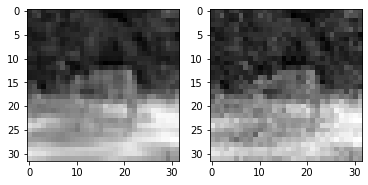

25  :  [0.9473932] 25
50  :  [0.9526926] 25
75  :  [0.9526926] 25
100  :  [0.95963866] 25
125  :  [0.96230984] 25
150  :  [0.9654274] 25
175  :  [0.9666364] 25
200  :  [0.9666364] 25
225  :  [0.9690921] 25
250  :  [0.9690921] 25
275  :  [0.9741392] 25
300  :  [0.9741392] 25
325  :  [0.9769696] 25
350  :  [0.9769696] 25
375  :  [0.97757375] 25
400  :  [0.97757375] 25
425  :  [0.97757375] 25
450  :  [0.9786426] 25
475  :  [0.9786426] 25
500  :  [0.9793949] 25
525  :  [0.97962564] 25
550  :  [0.98035145] 25
575  :  [0.9817268] 25
600  :  [0.98200256] 25
625  :  [0.98200256] 25
650  :  [0.9822532] 25
675  :  [0.98279595] 25
700  :  [0.98279595] 25
725  :  [0.9831679] 25
750  :  [0.9840026] 25
775  :  [0.9840026] 25
800  :  [0.98462284] 25
Time:  102.10587000846863  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


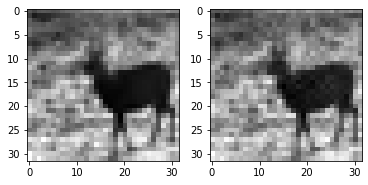

25  :  [0.9085734] 25
50  :  [0.9127872] 25
75  :  [0.9127872] 25
100  :  [0.91901284] 25
125  :  [0.91901284] 25
150  :  [0.91901284] 25
175  :  [0.91901284] 25
200  :  [0.921264] 25
225  :  [0.921264] 25
250  :  [0.921264] 25
275  :  [0.921264] 25
300  :  [0.921264] 25
325  :  [0.921264] 25
350  :  [0.921264] 25
375  :  [0.921264] 25
400  :  [0.921264] 25
425  :  [0.921264] 25
450  :  [0.921264] 25
475  :  [0.921264] 25
500  :  [0.921264] 25
525  :  [0.921264] 25
550  :  [0.921264] 25
575  :  [0.921264] 25
600  :  [0.9248539] 25
625  :  [0.9248539] 25
650  :  [0.9248539] 25
675  :  [0.9248539] 25
700  :  [0.9271386] 25
725  :  [0.9271386] 25
750  :  [0.9305726] 25
775  :  [0.9305726] 25
800  :  [0.9305726] 25
Time:  99.12283897399902  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


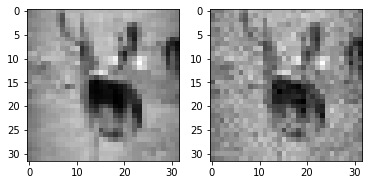

25  :  [0.9204813] 25
50  :  [0.9204813] 25
75  :  [0.9204813] 25
100  :  [0.9204813] 25
125  :  [0.9204813] 25
150  :  [0.9332947] 25
175  :  [0.94984096] 25
200  :  [0.94984096] 25
225  :  [0.94984096] 25
250  :  [0.94984096] 25
275  :  [0.94984096] 25
300  :  [0.94984096] 25
325  :  [0.94984096] 25
350  :  [0.9534385] 25
375  :  [0.9534385] 25
400  :  [0.9536321] 25
425  :  [0.9536321] 25
450  :  [0.9552216] 25
475  :  [0.9552216] 25
500  :  [0.9552216] 25
525  :  [0.9552733] 25
550  :  [0.9568528] 25
575  :  [0.95744866] 25
600  :  [0.95918006] 25
625  :  [0.9620534] 25
650  :  [0.9620534] 25
675  :  [0.96323776] 25
700  :  [0.96347106] 25
725  :  [0.96375656] 25
750  :  [0.9639629] 25
775  :  [0.9640888] 25
800  :  [0.9640888] 25
825  :  [0.9640888] 25
850  :  [0.96421874] 25
875  :  [0.9643247] 25
900  :  [0.96446884] 25
925  :  [0.9645258] 25
950  :  [0.9645705] 25
Time:  122.81801652908325  seconds
Original class:  4
Prediction for normal image:  [3]
Prediction for adversarial 

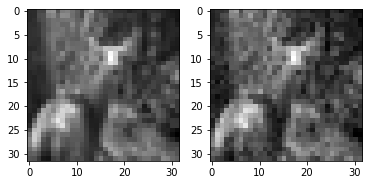

25  :  [0.8152874] 25
50  :  [0.8152874] 25
75  :  [0.8251925] 25
100  :  [0.8251925] 25
125  :  [0.83798325] 25
150  :  [0.8398013] 25
175  :  [0.8556433] 25
200  :  [0.8556433] 25
225  :  [0.8556433] 25
250  :  [0.8561113] 25
275  :  [0.862922] 25
300  :  [0.862922] 25
325  :  [0.87012184] 25
350  :  [0.87726784] 25
375  :  [0.89316094] 25
400  :  [0.89316094] 25
425  :  [0.8934756] 25
450  :  [0.8934756] 25
475  :  [0.8961563] 25
500  :  [0.9004873] 25
525  :  [0.9004873] 25
550  :  [0.90232635] 25
575  :  [0.90232635] 25
600  :  [0.908726] 25
625  :  [0.90906394] 25
650  :  [0.9135258] 25
675  :  [0.9145703] 25
700  :  [0.9169153] 25
725  :  [0.92090404] 25
750  :  [0.92357033] 25
775  :  [0.92357033] 25
800  :  [0.92357033] 25
825  :  [0.92357033] 25
850  :  [0.9236536] 25
875  :  [0.9236536] 25
900  :  [0.923802] 25
925  :  [0.923802] 25
950  :  [0.92400986] 25
975  :  [0.92454505] 25
1000  :  [0.92485404] 25
1025  :  [0.92515635] 25
1050  :  [0.92522585] 25
1075  :  [0.92571646]

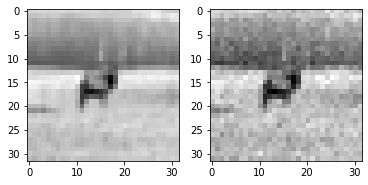

25  :  [0.83791465] 25
50  :  [0.83791465] 25
75  :  [0.8419633] 25
100  :  [0.8492707] 25
125  :  [0.8492707] 25
150  :  [0.8674165] 25
175  :  [0.89570093] 25
200  :  [0.89570093] 25
225  :  [0.89570093] 25
250  :  [0.89570093] 25
275  :  [0.89570093] 25
300  :  [0.9164003] 25
325  :  [0.9164003] 25
350  :  [0.9164003] 25
375  :  [0.9164003] 25
400  :  [0.92002314] 25
425  :  [0.92002314] 25
450  :  [0.922625] 25
475  :  [0.9315368] 25
500  :  [0.9386172] 25
525  :  [0.9399965] 25
550  :  [0.9399965] 25
575  :  [0.9408207] 25
600  :  [0.94166994] 25
625  :  [0.9418427] 25
650  :  [0.9420945] 25
675  :  [0.9439373] 25
700  :  [0.9439373] 25
725  :  [0.94418615] 25
750  :  [0.94424605] 25
775  :  [0.94576585] 25
800  :  [0.9461397] 25
825  :  [0.9465215] 25
850  :  [0.946815] 25
875  :  [0.9469062] 25
900  :  [0.9469062] 25
925  :  [0.94706225] 25
950  :  [0.94706225] 25
975  :  [0.9471146] 25
1000  :  [0.94716334] 25
1025  :  [0.94716334] 25
1050  :  [0.9471813] 25
1075  :  [0.9472479

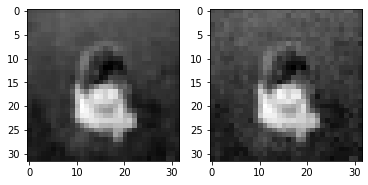

25  :  [0.8981699] 25
50  :  [0.8981699] 25
75  :  [0.8981699] 25
100  :  [0.8981699] 25
125  :  [0.8981699] 25
150  :  [0.8981699] 25
175  :  [0.8981699] 25
200  :  [0.8981699] 25
225  :  [0.8981699] 25
250  :  [0.8981699] 25
275  :  [0.8981699] 25
300  :  [0.90653956] 25
325  :  [0.90653956] 25
350  :  [0.90653956] 25
375  :  [0.90653956] 25
400  :  [0.90653956] 25
425  :  [0.9123532] 25
450  :  [0.9123532] 25
475  :  [0.9123532] 25
500  :  [0.9123532] 25
525  :  [0.9127891] 25
550  :  [0.9127891] 25
575  :  [0.9201207] 25
600  :  [0.9201207] 25
625  :  [0.93021905] 25
650  :  [0.93021905] 25
675  :  [0.93021905] 25
700  :  [0.93021905] 25
725  :  [0.93021905] 25
750  :  [0.93021905] 25
775  :  [0.93021905] 25
800  :  [0.93021905] 25
825  :  [0.93021905] 25
850  :  [0.93021905] 25
875  :  [0.93021905] 25
900  :  [0.93021905] 25
925  :  [0.93021905] 25
950  :  [0.93021905] 25
975  :  [0.93021905] 25
1000  :  [0.93021905] 25
1025  :  [0.93021905] 25
1050  :  [0.93021905] 25
1075  :  [0

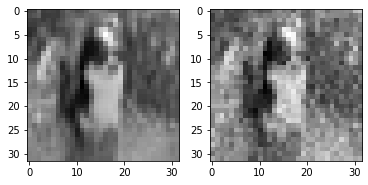

25  :  [0.9091316] 25
50  :  [0.9091316] 25
75  :  [0.91646063] 25
100  :  [0.91646063] 25
125  :  [0.91646063] 25
150  :  [0.91646063] 25
175  :  [0.91646063] 25
200  :  [0.9167355] 25
225  :  [0.92454225] 25
250  :  [0.9298488] 25
275  :  [0.9298488] 25
300  :  [0.93802917] 25
325  :  [0.93802917] 25
350  :  [0.93802917] 25
375  :  [0.93802917] 25
400  :  [0.93802917] 25
425  :  [0.93802917] 25
450  :  [0.93802917] 25
475  :  [0.93802917] 25
500  :  [0.93802917] 25
525  :  [0.93802917] 25
550  :  [0.93802917] 25
575  :  [0.93802917] 25
600  :  [0.93802917] 25
625  :  [0.93802917] 25
650  :  [0.93802917] 25
675  :  [0.93802917] 25
700  :  [0.93802917] 25
725  :  [0.93802917] 25
750  :  [0.93802917] 25
775  :  [0.93802917] 25
800  :  [0.93802917] 25
Time:  97.38647866249084  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


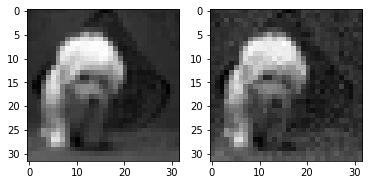

25  :  [0.936748] 25
50  :  [0.936748] 25
75  :  [0.936748] 25
100  :  [0.936748] 25
125  :  [0.936748] 25
150  :  [0.936748] 25
175  :  [0.936748] 25
200  :  [0.936748] 25
225  :  [0.9440162] 25
250  :  [0.94419444] 25
275  :  [0.94419444] 25
300  :  [0.94419444] 25
325  :  [0.94419444] 25
350  :  [0.94419444] 25
375  :  [0.94480884] 25
400  :  [0.94480884] 25
425  :  [0.94802207] 25
450  :  [0.94802207] 25
475  :  [0.94802207] 25
500  :  [0.94989955] 25
525  :  [0.94989955] 25
550  :  [0.95326686] 25
575  :  [0.9553968] 25
600  :  [0.95834625] 25
625  :  [0.9594679] 25
650  :  [0.9594679] 25
675  :  [0.9615449] 25
700  :  [0.9615452] 25
725  :  [0.9624717] 25
750  :  [0.9632525] 25
775  :  [0.9632525] 25
800  :  [0.9636594] 25
Time:  96.93218946456909  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


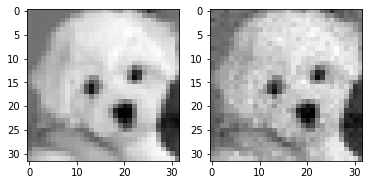

25  :  [0.9438887] 25
50  :  [0.94611144] 25
75  :  [0.95635235] 25
100  :  [0.95635235] 25
125  :  [0.95635235] 25
150  :  [0.9563738] 25
175  :  [0.95646036] 25
200  :  [0.96122575] 25
225  :  [0.9651565] 25
250  :  [0.9651565] 25
275  :  [0.96528685] 25
300  :  [0.9714205] 25
325  :  [0.97447264] 25
350  :  [0.97513974] 25
375  :  [0.97596836] 25
400  :  [0.97810555] 25
425  :  [0.97810555] 25
450  :  [0.97834957] 25
475  :  [0.97905266] 25
500  :  [0.97905266] 25
525  :  [0.9820246] 25
550  :  [0.9820246] 25
575  :  [0.98236465] 25
600  :  [0.98236465] 25
625  :  [0.9824785] 25
650  :  [0.98269725] 25
675  :  [0.98269725] 25
700  :  [0.98277104] 25
725  :  [0.98277754] 25
750  :  [0.98277855] 25
775  :  [0.98295355] 25
800  :  [0.98302644] 25
825  :  [0.98310995] 25
850  :  [0.98317397] 25
Time:  103.25804495811462  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


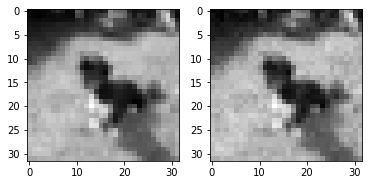

25  :  [0.9153372] 25
50  :  [0.92942476] 25
75  :  [0.92942476] 25
100  :  [0.92942476] 25
125  :  [0.9294813] 25
150  :  [0.9317982] 25
175  :  [0.9317982] 25
200  :  [0.935861] 25
225  :  [0.9397196] 25
250  :  [0.9397196] 25
275  :  [0.94498026] 25
300  :  [0.94498026] 25
325  :  [0.94498026] 25
350  :  [0.9478431] 25
375  :  [0.9478431] 25
400  :  [0.9478431] 25
425  :  [0.9520753] 25
450  :  [0.95427275] 25
475  :  [0.95427275] 25
500  :  [0.95427275] 25
525  :  [0.95427275] 25
550  :  [0.95427275] 25
575  :  [0.95427275] 25
600  :  [0.95427275] 25
625  :  [0.9553728] 25
650  :  [0.9559586] 25
675  :  [0.9559586] 25
700  :  [0.9567333] 25
725  :  [0.95838696] 25
750  :  [0.9589038] 25
775  :  [0.9589038] 25
800  :  [0.95961535] 25
825  :  [0.9603518] 25
Time:  99.92358541488647  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


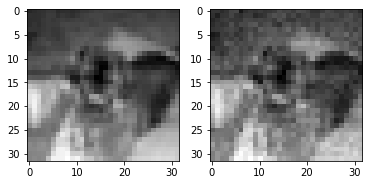

25  :  [0.89326] 25
50  :  [0.89326] 25
75  :  [0.8954638] 25
100  :  [0.8956021] 25
125  :  [0.8956021] 25
150  :  [0.8956021] 25
175  :  [0.8956021] 25
200  :  [0.8996471] 25
225  :  [0.89963937] 25
250  :  [0.90221715] 25
275  :  [0.9073484] 25
300  :  [0.9082358] 25
325  :  [0.9082358] 25
350  :  [0.9082358] 25
375  :  [0.9147507] 25
400  :  [0.9147507] 25
425  :  [0.9147507] 25
450  :  [0.91980815] 25
475  :  [0.92006993] 25
500  :  [0.9228848] 25
525  :  [0.9228848] 25
550  :  [0.9228848] 25
575  :  [0.92498183] 25
600  :  [0.9252466] 25
625  :  [0.9252466] 25
650  :  [0.92717886] 25
675  :  [0.9289589] 25
700  :  [0.9289589] 25
725  :  [0.9289589] 25
750  :  [0.9306302] 25
775  :  [0.9306302] 25
800  :  [0.9306302] 25
Time:  98.66441893577576  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


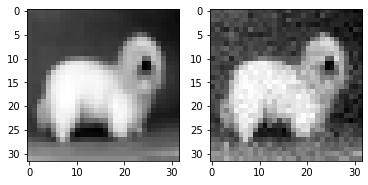

25  :  [0.8898169] 25
50  :  [0.91627717] 25
75  :  [0.93043506] 25
100  :  [0.9444727] 25
125  :  [0.9444898] 25
150  :  [0.9444898] 25
175  :  [0.9444898] 25
200  :  [0.9444898] 25
225  :  [0.94794524] 25
250  :  [0.94853014] 25
275  :  [0.94853014] 25
300  :  [0.94853014] 25
325  :  [0.9552635] 25
350  :  [0.95536757] 25
375  :  [0.95536757] 25
400  :  [0.95536757] 25
425  :  [0.95536757] 25
450  :  [0.95959616] 25
475  :  [0.96242785] 25
500  :  [0.96242785] 25
525  :  [0.96442056] 25
550  :  [0.96442056] 25
575  :  [0.96442056] 25
600  :  [0.96442056] 25
625  :  [0.96442056] 25
650  :  [0.96442056] 25
675  :  [0.96442056] 25
700  :  [0.96442056] 25
725  :  [0.96442056] 25
750  :  [0.96442056] 25
775  :  [0.96442056] 25
800  :  [0.96442056] 25
825  :  [0.96442056] 25
850  :  [0.96442056] 25
875  :  [0.96442056] 25
Time:  104.35915493965149  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [6]


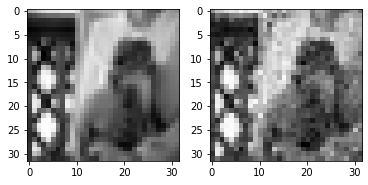

25  :  [0.8333709] 25
50  :  [0.8367847] 25
75  :  [0.87646985] 25
100  :  [0.8721172] 25
125  :  [0.8789946] 25
150  :  [0.8748693] 25
175  :  [0.8721172] 25
200  :  [0.8721172] 25
225  :  [0.8863555] 25
250  :  [0.8863555] 25
275  :  [0.8863555] 25
300  :  [0.893763] 25
325  :  [0.8858708] 25
350  :  [0.88856995] 25
375  :  [0.895295] 25
400  :  [0.8953799] 25
425  :  [0.89787805] 25
450  :  [0.90343225] 25
475  :  [0.91291404] 25
500  :  [0.91155493] 25
525  :  [0.9136896] 25
550  :  [0.9131144] 25
575  :  [0.9210615] 25
600  :  [0.9210615] 25
625  :  [0.92258406] 25
650  :  [0.9225286] 25
675  :  [0.9225286] 25
700  :  [0.9225286] 25
725  :  [0.93741673] 25
750  :  [0.93741673] 25
775  :  [0.9406507] 25
800  :  [0.9411945] 25
825  :  [0.94366014] 25
850  :  [0.94597363] 25
875  :  [0.9512589] 25
900  :  [0.95695823] 25
925  :  [0.95695823] 25
950  :  [0.95695823] 25
975  :  [0.95695823] 25
1000  :  [0.95695823] 25
1025  :  [0.95695823] 25
1050  :  [0.95695823] 25
1075  :  [0.958157

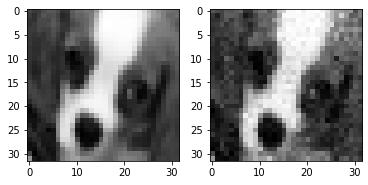

25  :  [0.9088805] 25
50  :  [0.92706776] 25
75  :  [0.92703235] 25
100  :  [0.9341999] 25
125  :  [0.9337572] 25
150  :  [0.9337572] 25
175  :  [0.9337572] 25
200  :  [0.9337572] 25
225  :  [0.9337572] 25
250  :  [0.9337572] 25
275  :  [0.9337572] 25
300  :  [0.9337572] 25
325  :  [0.9337572] 25
350  :  [0.9337572] 25
375  :  [0.94166386] 25
400  :  [0.94166386] 25
425  :  [0.94380295] 25
450  :  [0.94380295] 25
475  :  [0.94380295] 25
500  :  [0.9460981] 25
525  :  [0.94924825] 25
550  :  [0.9492508] 25
575  :  [0.9496604] 25
600  :  [0.9496604] 25
625  :  [0.9496604] 25
650  :  [0.9505091] 25
675  :  [0.9535263] 25
700  :  [0.9551693] 25
725  :  [0.9551693] 25
750  :  [0.95902765] 25
775  :  [0.95902765] 25
800  :  [0.95902765] 25
825  :  [0.95902765] 25
Time:  99.23656225204468  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [4]


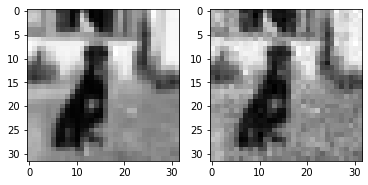

25  :  [0.8909985] 25
50  :  [0.8909985] 25
75  :  [0.89178747] 25
100  :  [0.8909985] 25
125  :  [0.8909985] 25
150  :  [0.8909985] 25
175  :  [0.8909985] 25
200  :  [0.8909985] 25
225  :  [0.9205926] 25
250  :  [0.9205926] 25
275  :  [0.9205926] 25
300  :  [0.9205926] 25
325  :  [0.9205926] 25
350  :  [0.9205926] 25
375  :  [0.9205926] 25
400  :  [0.9205926] 25
425  :  [0.9205926] 25
450  :  [0.9205926] 25
475  :  [0.9205926] 25
500  :  [0.9205926] 25
525  :  [0.9205926] 25
550  :  [0.9205926] 25
575  :  [0.92156804] 25
600  :  [0.9280704] 25
625  :  [0.9280704] 25
650  :  [0.9280704] 25
675  :  [0.9316533] 25
700  :  [0.93425226] 25
725  :  [0.94114506] 25
750  :  [0.94114506] 25
775  :  [0.94319415] 25
800  :  [0.94347143] 25
825  :  [0.94335496] 25
850  :  [0.94335496] 25
875  :  [0.9434335] 25
900  :  [0.9474225] 25
925  :  [0.9474225] 25
950  :  [0.9485399] 25
975  :  [0.95169675] 25
1000  :  [0.952386] 25
Time:  120.37443232536316  seconds
Original class:  5
Prediction for norm

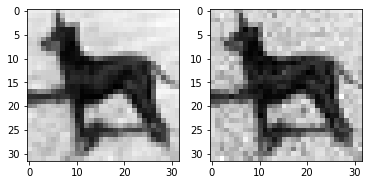

25  :  [0.9199487] 25
50  :  [0.9199487] 25
75  :  [0.9416863] 25
100  :  [0.9416863] 25
125  :  [0.94203836] 25
150  :  [0.94477016] 25
175  :  [0.944783] 25
200  :  [0.944783] 25
225  :  [0.944783] 25
250  :  [0.944783] 25
275  :  [0.944783] 25
300  :  [0.944783] 25
325  :  [0.944783] 25
350  :  [0.9450653] 25
375  :  [0.9450653] 25
400  :  [0.9450653] 25
425  :  [0.9450653] 25
450  :  [0.9450653] 25
475  :  [0.9484771] 25
500  :  [0.94917196] 25
525  :  [0.94917196] 25
550  :  [0.95039064] 25
575  :  [0.9519263] 25
600  :  [0.9523298] 25
625  :  [0.9574221] 25
650  :  [0.9574209] 25
675  :  [0.96360415] 25
700  :  [0.96360415] 25
725  :  [0.96360415] 25
750  :  [0.9642709] 25
775  :  [0.9651224] 25
800  :  [0.9659834] 25
825  :  [0.9659834] 25
850  :  [0.9659834] 25
Time:  106.69669651985168  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [3]


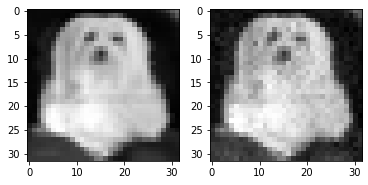

25  :  [0.9403963] 25
50  :  [0.9438467] 25
75  :  [0.93041927] 25
100  :  [0.93041927] 25
125  :  [0.93041927] 25
150  :  [0.93041927] 25
175  :  [0.93041927] 25
200  :  [0.93381673] 25
225  :  [0.93533504] 25
250  :  [0.93533504] 25
275  :  [0.93533504] 25
300  :  [0.9356847] 25
325  :  [0.9385313] 25
350  :  [0.94211185] 25
375  :  [0.9469588] 25
400  :  [0.9465109] 25
425  :  [0.95166737] 25
450  :  [0.9518853] 25
475  :  [0.95735174] 25
500  :  [0.96183264] 25
525  :  [0.96183264] 25
550  :  [0.96183264] 25
575  :  [0.9652271] 25
600  :  [0.9652271] 25
625  :  [0.96558964] 25
650  :  [0.96558964] 25
675  :  [0.9657463] 25
700  :  [0.96648324] 25
725  :  [0.96648324] 25
750  :  [0.96672124] 25
775  :  [0.96693885] 25
800  :  [0.96706986] 25
825  :  [0.9671687] 25
850  :  [0.9671803] 25
Time:  104.43756318092346  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


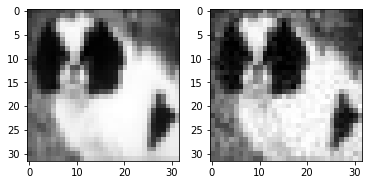

25  :  [0.9225395] 25
50  :  [0.9225395] 25
75  :  [0.9225395] 25
100  :  [0.9421039] 25
125  :  [0.9421039] 25
150  :  [0.9421039] 25
175  :  [0.9421039] 25
200  :  [0.9421039] 25
225  :  [0.9421039] 25
250  :  [0.9421039] 25
275  :  [0.9498569] 25
300  :  [0.9498569] 25
325  :  [0.9498569] 25
350  :  [0.9498569] 25
375  :  [0.9498569] 25
400  :  [0.9498569] 25
425  :  [0.9498569] 25
450  :  [0.9498569] 25
475  :  [0.9498569] 25
500  :  [0.9548297] 25
525  :  [0.95712054] 25
550  :  [0.9590197] 25
575  :  [0.9606677] 25
600  :  [0.9621439] 25
625  :  [0.9621439] 25
650  :  [0.9627799] 25
675  :  [0.96362853] 25
700  :  [0.9649689] 25
725  :  [0.96568465] 25
750  :  [0.96568465] 25
775  :  [0.96568465] 25
800  :  [0.96568465] 25
825  :  [0.96614194] 25
850  :  [0.96614194] 25
875  :  [0.96614194] 25
Time:  106.59357357025146  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [3]


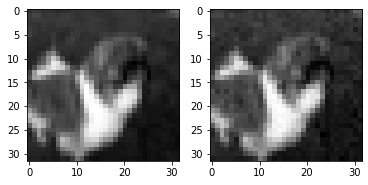

25  :  [0.45612225] 25
50  :  [0.53373444] 25
75  :  [0.54394263] 25
100  :  [0.5955594] 25
125  :  [0.6635645] 25
150  :  [0.6532998] 25
175  :  [0.6532998] 25
200  :  [0.7058803] 25
225  :  [0.7058803] 25
250  :  [0.7154068] 25
275  :  [0.7154068] 25
300  :  [0.7154068] 25
325  :  [0.7154068] 25
350  :  [0.7746809] 25
375  :  [0.7789506] 25
400  :  [0.77906543] 25
425  :  [0.77906543] 25
450  :  [0.7791765] 25
475  :  [0.79133064] 25
500  :  [0.7911744] 25
525  :  [0.7911744] 25
550  :  [0.79312164] 25
575  :  [0.79312164] 25
600  :  [0.79312164] 25
625  :  [0.79312164] 25
650  :  [0.79312164] 25
675  :  [0.79312164] 25
700  :  [0.82282233] 25
725  :  [0.82282233] 25
750  :  [0.83048177] 25
775  :  [0.833539] 25
800  :  [0.8349118] 25
825  :  [0.8349118] 25
850  :  [0.8349118] 25
875  :  [0.8410107] 25
900  :  [0.84305125] 25
925  :  [0.84405226] 25
950  :  [0.84405226] 25
975  :  [0.84405226] 25
1000  :  [0.84413743] 25
1025  :  [0.84413743] 25
1050  :  [0.8445307] 25
1075  :  [0.84

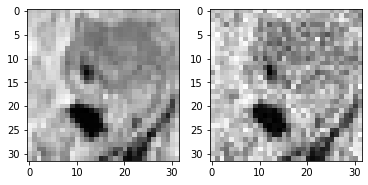

25  :  [0.8485266] 25
50  :  [0.8485266] 25
75  :  [0.8645134] 25
100  :  [0.918849] 25
125  :  [0.9394493] 25
150  :  [0.9394493] 25
175  :  [0.9394493] 25
200  :  [0.9394493] 25
225  :  [0.9394493] 25
250  :  [0.9394493] 25
275  :  [0.9394493] 25
300  :  [0.9394493] 25
325  :  [0.9394493] 25
350  :  [0.9394493] 25
375  :  [0.9394493] 25
400  :  [0.9394493] 25
425  :  [0.9394493] 25
450  :  [0.9394493] 25
475  :  [0.9394493] 25
500  :  [0.9394493] 25
525  :  [0.9394493] 25
550  :  [0.9394493] 25
575  :  [0.9394493] 25
600  :  [0.9394493] 25
625  :  [0.9394493] 25
650  :  [0.9394493] 25
675  :  [0.9394493] 25
700  :  [0.9447522] 25
725  :  [0.9447522] 25
750  :  [0.9496107] 25
775  :  [0.9496107] 25
800  :  [0.9496107] 25
825  :  [0.95146155] 25
850  :  [0.9527695] 25
875  :  [0.9527695] 25
900  :  [0.9557443] 25
Time:  106.05421662330627  seconds
Original class:  6
Prediction for normal image:  [6]
Prediction for adversarial image:  [2]


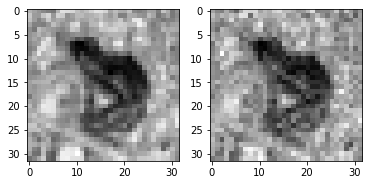

25  :  [0.8532881] 25
50  :  [0.8532881] 25
75  :  [0.8532881] 25
100  :  [0.8532881] 25
125  :  [0.8532881] 25
150  :  [0.8532881] 25
175  :  [0.8532881] 25
200  :  [0.8532881] 25
225  :  [0.8565086] 25
250  :  [0.8736751] 25
275  :  [0.8761722] 25
300  :  [0.87917244] 25
325  :  [0.8827758] 25
350  :  [0.8928678] 25
375  :  [0.8938743] 25
400  :  [0.9083084] 25
425  :  [0.9151803] 25
450  :  [0.9199101] 25
475  :  [0.9237952] 25
500  :  [0.92921007] 25
525  :  [0.92921007] 25
550  :  [0.93448806] 25
575  :  [0.93846804] 25
600  :  [0.93846804] 25
625  :  [0.93846804] 25
650  :  [0.93846804] 25
675  :  [0.9392153] 25
700  :  [0.9392153] 25
725  :  [0.9392153] 25
750  :  [0.9392691] 25
775  :  [0.9401956] 25
800  :  [0.9420898] 25
825  :  [0.94275945] 25
850  :  [0.94275945] 25
875  :  [0.94275945] 25
900  :  [0.94275945] 25
925  :  [0.9429549] 25
950  :  [0.9429549] 25
975  :  [0.94317436] 25
1000  :  [0.9432882] 25
1025  :  [0.9433781] 25
1050  :  [0.9433781] 25
1075  :  [0.9434604] 

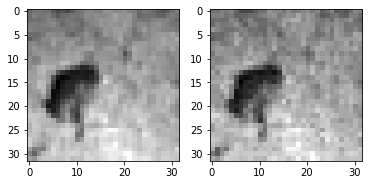

25  :  [0.4683131] 25
50  :  [0.71685547] 25
75  :  [0.64283603] 25
100  :  [0.6620112] 25
125  :  [0.6620112] 25
150  :  [0.6620112] 25
175  :  [0.6620112] 25
200  :  [0.6750312] 25
225  :  [0.67189336] 25
250  :  [0.67189336] 25
275  :  [0.6859452] 25
300  :  [0.6887426] 25
325  :  [0.71148545] 25
350  :  [0.71148545] 25
375  :  [0.71148545] 25
400  :  [0.71148545] 25
425  :  [0.7266199] 25
450  :  [0.7266199] 25
475  :  [0.7266199] 25
500  :  [0.7267132] 25
525  :  [0.7309806] 25
550  :  [0.7317299] 25
575  :  [0.7317299] 25
600  :  [0.7317299] 25
625  :  [0.73792297] 25
650  :  [0.746437] 25
675  :  [0.746437] 25
700  :  [0.7580205] 25
725  :  [0.7580205] 25
750  :  [0.7580205] 25
775  :  [0.7580205] 25
800  :  [0.759138] 25
825  :  [0.759138] 25
850  :  [0.7638643] 25
875  :  [0.7638643] 25
900  :  [0.7638643] 25
925  :  [0.76813877] 25
950  :  [0.7681604] 25
975  :  [0.7681604] 25
1000  :  [0.7681604] 25
1025  :  [0.76922387] 25
1050  :  [0.76922387] 25
1075  :  [0.77090263] 25
1

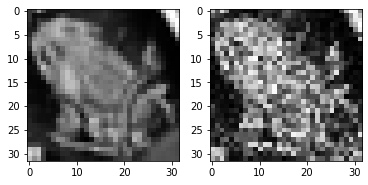

25  :  [0.67539304] 25
50  :  [0.67539304] 25
75  :  [0.6826685] 25
100  :  [0.6826685] 25
125  :  [0.6826685] 25
150  :  [0.6826685] 25
175  :  [0.6826685] 25
200  :  [0.6826685] 25
225  :  [0.6826685] 25
250  :  [0.6826685] 25
275  :  [0.6826685] 25
300  :  [0.69382286] 25
325  :  [0.7955177] 25
350  :  [0.7955177] 25
375  :  [0.7955177] 25
400  :  [0.7955177] 25
425  :  [0.7955177] 25
450  :  [0.7955177] 25
475  :  [0.7955177] 25
500  :  [0.7955177] 25
525  :  [0.7955177] 25
550  :  [0.7955177] 25
575  :  [0.7955177] 25
600  :  [0.7955177] 25
625  :  [0.7955177] 25
650  :  [0.7955177] 25
675  :  [0.7955177] 25
700  :  [0.7955177] 25
725  :  [0.7955177] 25
750  :  [0.7955177] 25
775  :  [0.7955177] 25
800  :  [0.8064046] 25
825  :  [0.80647266] 25
850  :  [0.8151674] 25
875  :  [0.8150755] 25
900  :  [0.8220563] 25
925  :  [0.8220563] 25
950  :  [0.8220563] 25
975  :  [0.82264423] 25
1000  :  [0.82264423] 25
1025  :  [0.83082426] 25
1050  :  [0.8363719] 25
1075  :  [0.8363719] 25
110

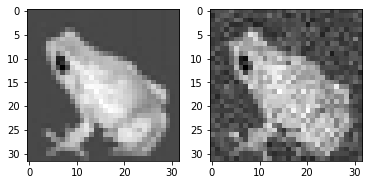

25  :  [0.780549] 25
50  :  [0.780549] 25
75  :  [0.5029206] 25
100  :  [0.6467929] 25
125  :  [0.7198206] 25
150  :  [0.7198206] 25
175  :  [0.7198206] 25
200  :  [0.7198206] 25
225  :  [0.72288084] 25
250  :  [0.7330366] 25
275  :  [0.7330366] 25
300  :  [0.7330366] 25
325  :  [0.7330366] 25
350  :  [0.7330366] 25
375  :  [0.7330366] 25
400  :  [0.7330366] 25
425  :  [0.7330366] 25
450  :  [0.7330366] 25
475  :  [0.7330366] 25
500  :  [0.7330366] 25
525  :  [0.7356241] 25
550  :  [0.7356241] 25
575  :  [0.7356241] 25
600  :  [0.7356241] 25
625  :  [0.7356241] 25
650  :  [0.7356241] 25
675  :  [0.7356241] 25
700  :  [0.7356241] 25
725  :  [0.75611234] 25
750  :  [0.7564868] 25
775  :  [0.7564868] 25
800  :  [0.7564868] 25
825  :  [0.7564868] 25
850  :  [0.7564868] 25
875  :  [0.7564868] 25
900  :  [0.7564868] 25
925  :  [0.7564868] 25
950  :  [0.7607213] 25
975  :  [0.76077586] 25
1000  :  [0.76077586] 25
1025  :  [0.76077586] 25
1050  :  [0.7659771] 25
1075  :  [0.77111393] 25
1100  

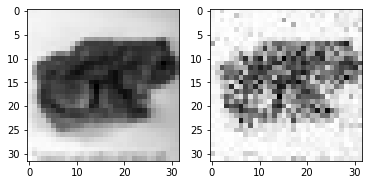

25  :  [0.68612564] 25
50  :  [0.8223387] 25
75  :  [0.8223387] 25
100  :  [0.85408413] 25
125  :  [0.85408413] 25
150  :  [0.85408413] 25
175  :  [0.85408413] 25
200  :  [0.85408413] 25
225  :  [0.85408413] 25
250  :  [0.85408413] 25
275  :  [0.85408413] 25
300  :  [0.85408413] 25
325  :  [0.86036956] 25
350  :  [0.86065066] 25
375  :  [0.86065066] 25
400  :  [0.86065066] 25
425  :  [0.86065066] 25
450  :  [0.8611517] 25
475  :  [0.8611517] 25
500  :  [0.8611517] 25
525  :  [0.8611517] 25
550  :  [0.8684697] 25
575  :  [0.8751893] 25
600  :  [0.8751893] 25
625  :  [0.8751893] 25
650  :  [0.8751893] 25
675  :  [0.8751893] 25
700  :  [0.8751893] 25
725  :  [0.8772087] 25
750  :  [0.8825755] 25
775  :  [0.8852825] 25
800  :  [0.8852825] 25
825  :  [0.8857104] 25
850  :  [0.88599503] 25
875  :  [0.8876648] 25
Time:  103.72343015670776  seconds
Original class:  6
Prediction for normal image:  [6]
Prediction for adversarial image:  [2]


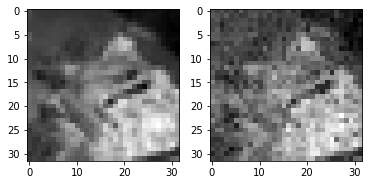

25  :  [0.34261125] 25
50  :  [0.44303325] 25
75  :  [0.696319] 25
100  :  [0.72927165] 25
125  :  [0.72927165] 25
150  :  [0.79287934] 25
175  :  [0.79511523] 25
200  :  [0.79511523] 25
225  :  [0.79511523] 25
250  :  [0.79511523] 25
275  :  [0.79511523] 25
300  :  [0.79511523] 25
325  :  [0.79511523] 25
350  :  [0.79511523] 25
375  :  [0.79511523] 25
400  :  [0.79511523] 25
425  :  [0.79511523] 25
450  :  [0.79511523] 25
475  :  [0.79511523] 25
500  :  [0.8107653] 25
525  :  [0.8107653] 25
550  :  [0.8107653] 25
575  :  [0.8107653] 25
600  :  [0.8127265] 25
625  :  [0.8130584] 25
650  :  [0.8130584] 25
675  :  [0.81450045] 25
700  :  [0.81449294] 25
725  :  [0.81449294] 25
750  :  [0.81449294] 25
775  :  [0.81867373] 25
800  :  [0.83480275] 25
825  :  [0.83625185] 25
850  :  [0.84978104] 25
875  :  [0.84978104] 25
900  :  [0.84978104] 25
925  :  [0.84978104] 25
950  :  [0.8522388] 25
975  :  [0.8522388] 25
1000  :  [0.85503423] 25
1025  :  [0.8597933] 25
1050  :  [0.8633965] 25
1075 

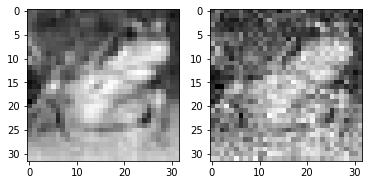

25  :  [0.65789986] 25
50  :  [0.65789986] 25
75  :  [0.6529126] 25
100  :  [0.6745292] 25
125  :  [0.6745292] 25
150  :  [0.6745292] 25
175  :  [0.6745292] 25
200  :  [0.6745292] 25
225  :  [0.6745292] 25
250  :  [0.6745292] 25
275  :  [0.679013] 25
300  :  [0.679013] 25
325  :  [0.679013] 25
350  :  [0.679013] 25
375  :  [0.679013] 25
400  :  [0.679013] 25
425  :  [0.679013] 25
450  :  [0.679013] 25
475  :  [0.679013] 25
500  :  [0.679013] 25
525  :  [0.679013] 25
550  :  [0.679013] 25
575  :  [0.679013] 25
600  :  [0.679013] 25
625  :  [0.679013] 25
650  :  [0.7519705] 25
675  :  [0.7524998] 25
700  :  [0.7524998] 25
725  :  [0.7524998] 25
750  :  [0.777356] 25
775  :  [0.777356] 25
800  :  [0.777356] 25
825  :  [0.777356] 25
850  :  [0.777356] 25
875  :  [0.777356] 25
900  :  [0.777356] 25
925  :  [0.777356] 25
950  :  [0.7815932] 25
975  :  [0.7874391] 25
1000  :  [0.7884476] 25
1025  :  [0.7904948] 25
1050  :  [0.7904948] 25
1075  :  [0.7922151] 25
1100  :  [0.7925839] 25
1125  :

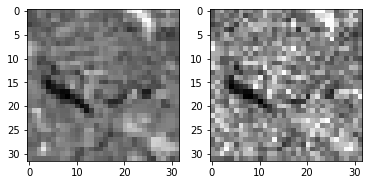

25  :  [0.10397878] 25
50  :  [0.22428595] 25
75  :  [0.3301848] 25
100  :  [0.6765904] 25
125  :  [0.7337196] 25
150  :  [0.72731173] 25
175  :  [0.72731173] 25
200  :  [0.7519057] 25
225  :  [0.7532294] 25
250  :  [0.7957928] 25
275  :  [0.7957928] 25
300  :  [0.7957928] 25
325  :  [0.7957928] 25
350  :  [0.7957928] 25
375  :  [0.7957928] 25
400  :  [0.7957928] 25
425  :  [0.7957928] 25
450  :  [0.7957928] 25
475  :  [0.7957928] 25
500  :  [0.7957928] 25
525  :  [0.7957928] 25
550  :  [0.7957928] 25
575  :  [0.7957928] 25
600  :  [0.7957928] 25
625  :  [0.7957928] 25
650  :  [0.8204348] 25
675  :  [0.8204348] 25
700  :  [0.823084] 25
725  :  [0.8230865] 25
750  :  [0.8230865] 25
775  :  [0.8248197] 25
800  :  [0.8248197] 25
825  :  [0.8248197] 25
850  :  [0.8426138] 25
875  :  [0.8426138] 25
900  :  [0.8426138] 25
925  :  [0.8485467] 25
950  :  [0.8485467] 25
975  :  [0.8485467] 25
1000  :  [0.8485467] 25
1025  :  [0.8485467] 25
1050  :  [0.85185933] 25
1075  :  [0.8535575] 25
1100  

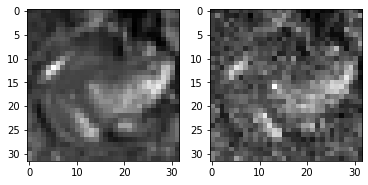

25  :  [0.02908263] 25
50  :  [0.46061212] 25
75  :  [0.5655694] 25
100  :  [0.5585386] 25
125  :  [0.5745083] 25
150  :  [0.6350936] 25
175  :  [0.67062247] 25
200  :  [0.6918039] 25
225  :  [0.6526536] 25
250  :  [0.67276317] 25
275  :  [0.67276317] 25
300  :  [0.67276317] 25
325  :  [0.67276317] 25
350  :  [0.67276317] 25
375  :  [0.67276317] 25
400  :  [0.67276317] 25
425  :  [0.67276317] 25
450  :  [0.67276317] 25
475  :  [0.67276317] 25
500  :  [0.67276317] 25
525  :  [0.67276317] 25
550  :  [0.67276317] 25
575  :  [0.67276317] 25
600  :  [0.694613] 25
625  :  [0.6968828] 25
650  :  [0.6968828] 25
675  :  [0.6968828] 25
700  :  [0.6968828] 25
725  :  [0.6989615] 25
750  :  [0.70035183] 25
775  :  [0.70385087] 25
800  :  [0.7111784] 25
825  :  [0.7112807] 25
850  :  [0.7127141] 25
875  :  [0.72167206] 25
900  :  [0.729823] 25
925  :  [0.73859835] 25
950  :  [0.7548337] 25
975  :  [0.7542274] 25
1000  :  [0.75477684] 25
1025  :  [0.7613627] 25
1050  :  [0.7613627] 25
1075  :  [0.76

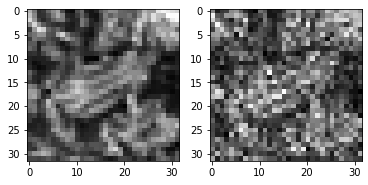

25  :  [0.23789945] 25
50  :  [0.48150718] 25
75  :  [0.49157116] 25
100  :  [0.5306009] 25
125  :  [0.5183923] 25
150  :  [0.55360353] 25
175  :  [0.62025106] 25
200  :  [0.6312876] 25
225  :  [0.6732939] 25
250  :  [0.6850978] 25
275  :  [0.6850978] 25
300  :  [0.6850978] 25
325  :  [0.7787302] 25
350  :  [0.7787302] 25
375  :  [0.7787302] 25
400  :  [0.7787302] 25
425  :  [0.7787302] 25
450  :  [0.7787302] 25
475  :  [0.7787302] 25
500  :  [0.7787302] 25
525  :  [0.7787302] 25
550  :  [0.7787302] 25
575  :  [0.7787302] 25
600  :  [0.7787302] 25
625  :  [0.7787302] 25
650  :  [0.7787302] 25
675  :  [0.7787302] 25
700  :  [0.78198665] 25
725  :  [0.78190124] 25
750  :  [0.78190124] 25
775  :  [0.78190124] 25
800  :  [0.78190124] 25
825  :  [0.78190124] 25
850  :  [0.78190124] 25
875  :  [0.78190124] 25
900  :  [0.78190124] 25
925  :  [0.78190124] 25
950  :  [0.78190124] 25
975  :  [0.78190124] 25
1000  :  [0.78190124] 25
1025  :  [0.78190124] 25
1050  :  [0.78190124] 25
1075  :  [0.78

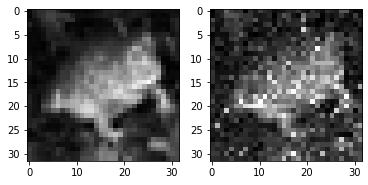

25  :  [0.21708488] 25
50  :  [0.51151234] 25
75  :  [0.39089566] 25
100  :  [0.40776104] 25
125  :  [0.40242785] 25
150  :  [0.55873847] 25
175  :  [0.5428567] 25
200  :  [0.5428567] 25
225  :  [0.5428567] 25
250  :  [0.57731295] 25
275  :  [0.57731295] 25
300  :  [0.57731295] 25
325  :  [0.57731295] 25
350  :  [0.57731295] 25
375  :  [0.57731295] 25
400  :  [0.57731295] 25
425  :  [0.57731295] 25
450  :  [0.57731295] 25
475  :  [0.57731295] 25
500  :  [0.57731295] 25
525  :  [0.57731295] 25
550  :  [0.57731295] 25
575  :  [0.5776002] 25
600  :  [0.5776002] 25
625  :  [0.57888675] 25
650  :  [0.58401114] 25
675  :  [0.5850531] 25
700  :  [0.59010744] 25
725  :  [0.6051808] 25
750  :  [0.60586786] 25
775  :  [0.60586786] 25
800  :  [0.6089182] 25
825  :  [0.60895616] 25
850  :  [0.61283195] 25
875  :  [0.61293286] 25
900  :  [0.6158407] 25
925  :  [0.6183147] 25
950  :  [0.62043047] 25
975  :  [0.62075734] 25
1000  :  [0.62324756] 25
1025  :  [0.62388116] 25
1050  :  [0.6257843] 25
107

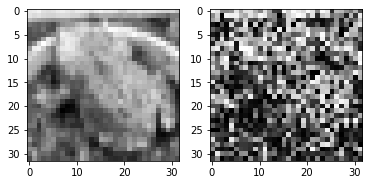

25  :  [0.873178] 25
50  :  [0.873178] 25
75  :  [0.87376714] 25
100  :  [0.87376714] 25
125  :  [0.87376714] 25
150  :  [0.87376714] 25
175  :  [0.87376714] 25
200  :  [0.87376714] 25
225  :  [0.87376714] 25
250  :  [0.87376714] 25
275  :  [0.87376714] 25
300  :  [0.87376714] 25
325  :  [0.87376714] 25
350  :  [0.87376714] 25
375  :  [0.87376714] 25
400  :  [0.87376714] 25
425  :  [0.87376714] 25
450  :  [0.88074183] 25
475  :  [0.8877102] 25
500  :  [0.89469284] 25
525  :  [0.89469284] 25
550  :  [0.89469284] 25
575  :  [0.89469284] 25
600  :  [0.8954034] 25
625  :  [0.8959174] 25
650  :  [0.8959174] 25
675  :  [0.8988987] 25
700  :  [0.8988987] 25
725  :  [0.8988987] 25
750  :  [0.8988987] 25
775  :  [0.8988987] 25
800  :  [0.8988987] 25
Time:  92.8286383152008  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [4]


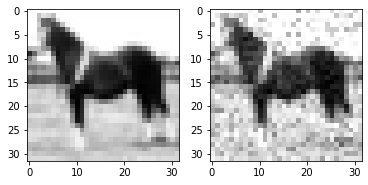

25  :  [0.86096334] 25
50  :  [0.86096334] 25
75  :  [0.8837066] 25
100  :  [0.8878361] 25
125  :  [0.8878361] 25
150  :  [0.8878361] 25
175  :  [0.8878361] 25
200  :  [0.8878361] 25
225  :  [0.8878361] 25
250  :  [0.8878361] 25
275  :  [0.9000816] 25
300  :  [0.90045786] 25
325  :  [0.90315986] 25
350  :  [0.9048598] 25
375  :  [0.90545225] 25
400  :  [0.9063726] 25
425  :  [0.9063726] 25
450  :  [0.91063565] 25
475  :  [0.9110797] 25
500  :  [0.9113723] 25
525  :  [0.91651666] 25
550  :  [0.9173702] 25
575  :  [0.91957855] 25
600  :  [0.91957855] 25
625  :  [0.91957855] 25
650  :  [0.9204168] 25
675  :  [0.9204168] 25
700  :  [0.92092896] 25
725  :  [0.922045] 25
750  :  [0.92329353] 25
775  :  [0.92329353] 25
800  :  [0.92397434] 25
825  :  [0.92397434] 25
850  :  [0.9240246] 25
875  :  [0.92434114] 25
900  :  [0.9249104] 25
925  :  [0.92499846] 25
950  :  [0.9250522] 25
975  :  [0.9252546] 25
1000  :  [0.9252546] 25
1025  :  [0.9253015] 25
1050  :  [0.9254561] 25
Time:  124.2574951

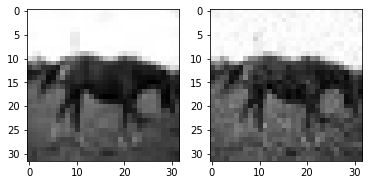

25  :  [0.90924656] 25
50  :  [0.90924656] 25
75  :  [0.90924656] 25
100  :  [0.9164262] 25
125  :  [0.918622] 25
150  :  [0.918597] 25
175  :  [0.92403007] 25
200  :  [0.92400813] 25
225  :  [0.9251658] 25
250  :  [0.9413557] 25
275  :  [0.9413557] 25
300  :  [0.9413557] 25
325  :  [0.9413557] 25
350  :  [0.9413557] 25
375  :  [0.9413557] 25
400  :  [0.9413557] 25
425  :  [0.9413557] 25
450  :  [0.9413557] 25
475  :  [0.9413557] 25
500  :  [0.9419356] 25
525  :  [0.9419356] 25
550  :  [0.94530714] 25
575  :  [0.9459734] 25
600  :  [0.9459734] 25
625  :  [0.9459734] 25
650  :  [0.94825566] 25
675  :  [0.94825566] 25
700  :  [0.9506955] 25
725  :  [0.9506955] 25
750  :  [0.9506955] 25
775  :  [0.95199233] 25
800  :  [0.95199233] 25
825  :  [0.95214605] 25
850  :  [0.95214605] 25
875  :  [0.95254827] 25
900  :  [0.95254827] 25
925  :  [0.9528611] 25
950  :  [0.9528611] 25
975  :  [0.95309806] 25
1000  :  [0.95309806] 25
1025  :  [0.95328736] 25
Time:  118.1686589717865  seconds
Original 

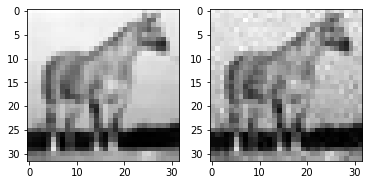

25  :  [0.8795829] 25
50  :  [0.9023399] 25
75  :  [0.9002468] 25
100  :  [0.9002468] 25
125  :  [0.9002468] 25
150  :  [0.90940547] 25
175  :  [0.90940547] 25
200  :  [0.92114204] 25
225  :  [0.92114127] 25
250  :  [0.92114127] 25
275  :  [0.92114127] 25
300  :  [0.92114127] 25
325  :  [0.92114127] 25
350  :  [0.92114127] 25
375  :  [0.92114127] 25
400  :  [0.92114127] 25
425  :  [0.92377126] 25
450  :  [0.9358293] 25
475  :  [0.93818593] 25
500  :  [0.93818593] 25
525  :  [0.93818593] 25
550  :  [0.93818593] 25
575  :  [0.93818593] 25
600  :  [0.9433198] 25
625  :  [0.9433198] 25
650  :  [0.9433198] 25
675  :  [0.9433198] 25
700  :  [0.9464184] 25
725  :  [0.94641757] 25
750  :  [0.94641757] 25
775  :  [0.9517587] 25
800  :  [0.9517587] 25
825  :  [0.95438653] 25
850  :  [0.95438653] 25
875  :  [0.9547482] 25
900  :  [0.95578337] 25
925  :  [0.95670015] 25
950  :  [0.95709884] 25
975  :  [0.9574473] 25
1000  :  [0.95751536] 25
1025  :  [0.95839846] 25
1050  :  [0.95904267] 25
1075  :

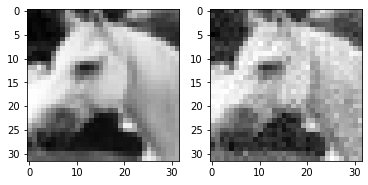

25  :  [0.8512432] 25
50  :  [0.85630655] 25
75  :  [0.8512432] 25
100  :  [0.8512432] 25
125  :  [0.8512432] 25
150  :  [0.8512432] 25
175  :  [0.8512432] 25
200  :  [0.8512432] 25
225  :  [0.86882776] 25
250  :  [0.8900068] 25
275  :  [0.9025853] 25
300  :  [0.9025853] 25
325  :  [0.9025853] 25
350  :  [0.9025853] 25
375  :  [0.90766466] 25
400  :  [0.9080242] 25
425  :  [0.90869045] 25
450  :  [0.90878737] 25
475  :  [0.91329336] 25
500  :  [0.91329336] 25
525  :  [0.91329336] 25
550  :  [0.91329336] 25
575  :  [0.9220464] 25
600  :  [0.9220573] 25
625  :  [0.92267966] 25
650  :  [0.92267966] 25
675  :  [0.92267966] 25
700  :  [0.92502326] 25
725  :  [0.9262881] 25
750  :  [0.9280744] 25
775  :  [0.9333955] 25
800  :  [0.9333955] 25
825  :  [0.9333955] 25
850  :  [0.93373066] 25
875  :  [0.93379056] 25
900  :  [0.9349202] 25
925  :  [0.9349202] 25
950  :  [0.93529636] 25
975  :  [0.93594486] 25
1000  :  [0.93594486] 25
1025  :  [0.93623483] 25
1050  :  [0.9368243] 25
Time:  121.8961

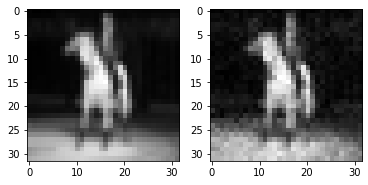

25  :  [0.83895797] 25
50  :  [0.8704319] 25
75  :  [0.8918977] 25
100  :  [0.9010329] 25
125  :  [0.9082665] 25
150  :  [0.9082665] 25
175  :  [0.9082665] 25
200  :  [0.91242546] 25
225  :  [0.91832435] 25
250  :  [0.9186557] 25
275  :  [0.91875553] 25
300  :  [0.91961384] 25
325  :  [0.9236856] 25
350  :  [0.92457044] 25
375  :  [0.92457044] 25
400  :  [0.93170416] 25
425  :  [0.940679] 25
450  :  [0.9431641] 25
475  :  [0.9450979] 25
500  :  [0.9450979] 25
525  :  [0.9450979] 25
550  :  [0.9467342] 25
575  :  [0.9467342] 25
600  :  [0.9467342] 25
625  :  [0.9467342] 25
650  :  [0.9475765] 25
675  :  [0.94806564] 25
700  :  [0.94806564] 25
725  :  [0.94866973] 25
750  :  [0.94885874] 25
775  :  [0.95106494] 25
800  :  [0.9532844] 25
825  :  [0.9532844] 25
850  :  [0.9532844] 25
Time:  100.04054045677185  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [4]


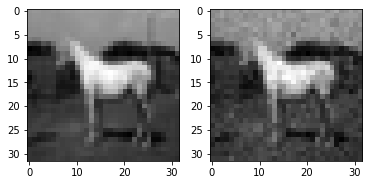

25  :  [0.93333745] 25
50  :  [0.93333745] 25
75  :  [0.93333745] 25
100  :  [0.93333745] 25
125  :  [0.93333745] 25
150  :  [0.93333745] 25
175  :  [0.9344032] 25
200  :  [0.9344032] 25
225  :  [0.9344032] 25
250  :  [0.9344032] 25
275  :  [0.9344032] 25
300  :  [0.9344032] 25
325  :  [0.9350766] 25
350  :  [0.9350766] 25
375  :  [0.93574154] 25
400  :  [0.9381385] 25
425  :  [0.93813574] 25
450  :  [0.9382735] 25
475  :  [0.9382735] 25
500  :  [0.9387853] 25
525  :  [0.9387853] 25
550  :  [0.9387853] 25
575  :  [0.9387853] 25
600  :  [0.9387853] 25
625  :  [0.9387853] 25
650  :  [0.9405999] 25
675  :  [0.9407662] 25
700  :  [0.9407662] 25
725  :  [0.9501571] 25
750  :  [0.9501571] 25
775  :  [0.95306873] 25
800  :  [0.95306873] 25
Time:  96.58827114105225  seconds
Original class:  7
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


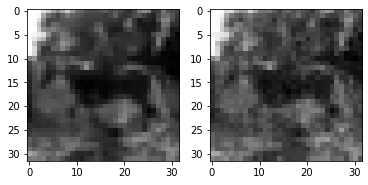

25  :  [0.9771438] 25
50  :  [0.9771438] 25
75  :  [0.9771438] 25
100  :  [0.97834647] 25
125  :  [0.97867477] 25
150  :  [0.98184437] 25
175  :  [0.98182356] 25
200  :  [0.98182356] 25
225  :  [0.98182356] 25
250  :  [0.9850867] 25
275  :  [0.9850867] 25
300  :  [0.9850867] 25
325  :  [0.9850867] 25
350  :  [0.9850867] 25
375  :  [0.9850867] 25
400  :  [0.98550624] 25
425  :  [0.98551214] 25
450  :  [0.98679566] 25
475  :  [0.987466] 25
500  :  [0.988152] 25
525  :  [0.98835516] 25
550  :  [0.98835516] 25
575  :  [0.98835516] 25
600  :  [0.988407] 25
625  :  [0.988407] 25
650  :  [0.9887809] 25
675  :  [0.9894595] 25
700  :  [0.9894595] 25
725  :  [0.9894595] 25
750  :  [0.98986876] 25
775  :  [0.989969] 25
800  :  [0.99004775] 25
Time:  95.60497260093689  seconds
Original class:  7
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


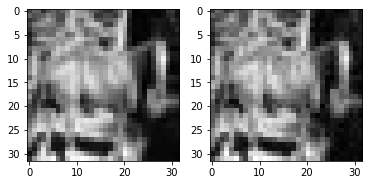

25  :  [0.9640021] 25
50  :  [0.96891904] 25
75  :  [0.9708029] 25
100  :  [0.9708029] 25
125  :  [0.9774501] 25
150  :  [0.9774501] 25
175  :  [0.97862816] 25
200  :  [0.979788] 25
225  :  [0.9822743] 25
250  :  [0.9847973] 25
275  :  [0.984828] 25
300  :  [0.98720074] 25
325  :  [0.98720074] 25
350  :  [0.98720074] 25
375  :  [0.98720074] 25
400  :  [0.9886553] 25
425  :  [0.9888749] 25
450  :  [0.9888749] 25
475  :  [0.9892497] 25
500  :  [0.9892497] 25
525  :  [0.9892497] 25
550  :  [0.99025536] 25
575  :  [0.99025536] 25
600  :  [0.99054587] 25
625  :  [0.99054587] 25
650  :  [0.99054587] 25
675  :  [0.99094343] 25
700  :  [0.99094343] 25
725  :  [0.99094343] 25
750  :  [0.99113536] 25
775  :  [0.99125654] 25
800  :  [0.99125654] 25
Time:  95.92935585975647  seconds
Original class:  7
Prediction for normal image:  [4]
Prediction for adversarial image:  [4]


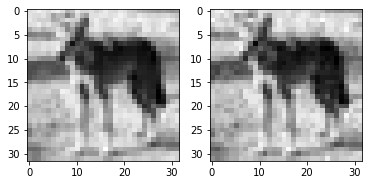

25  :  [0.9670087] 25
50  :  [0.9671979] 25
75  :  [0.96792626] 25
100  :  [0.96803826] 25
125  :  [0.9683986] 25
150  :  [0.9705589] 25
175  :  [0.9705508] 25
200  :  [0.9717989] 25
225  :  [0.97419846] 25
250  :  [0.9741974] 25
275  :  [0.9746134] 25
300  :  [0.9746371] 25
325  :  [0.9754964] 25
350  :  [0.97550434] 25
375  :  [0.977248] 25
400  :  [0.97725403] 25
425  :  [0.9799971] 25
450  :  [0.9831493] 25
475  :  [0.9831493] 25
500  :  [0.9831493] 25
525  :  [0.98418796] 25
550  :  [0.98418796] 25
575  :  [0.9843918] 25
600  :  [0.9858864] 25
625  :  [0.9858864] 25
650  :  [0.9858864] 25
675  :  [0.9861767] 25
700  :  [0.9872924] 25
725  :  [0.988047] 25
750  :  [0.988047] 25
775  :  [0.988047] 25
800  :  [0.9896128] 25
Time:  94.70557880401611  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


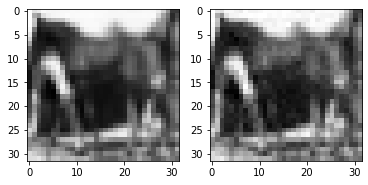

25  :  [0.95101446] 25
50  :  [0.95101446] 25
75  :  [0.9522606] 25
100  :  [0.9522606] 25
125  :  [0.9522606] 25
150  :  [0.9522606] 25
175  :  [0.9522606] 25
200  :  [0.9522606] 25
225  :  [0.9522606] 25
250  :  [0.9522606] 25
275  :  [0.95350194] 25
300  :  [0.9550356] 25
325  :  [0.95987785] 25
350  :  [0.96059847] 25
375  :  [0.96059847] 25
400  :  [0.9618708] 25
425  :  [0.9618708] 25
450  :  [0.9622596] 25
475  :  [0.96554536] 25
500  :  [0.96554536] 25
525  :  [0.96554536] 25
550  :  [0.9664854] 25
575  :  [0.96956325] 25
600  :  [0.9705674] 25
625  :  [0.9705674] 25
650  :  [0.9705674] 25
675  :  [0.9724851] 25
700  :  [0.9724851] 25
725  :  [0.972988] 25
750  :  [0.972988] 25
775  :  [0.972988] 25
800  :  [0.972988] 25
Time:  93.71008133888245  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


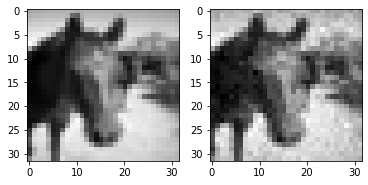

25  :  [0.9431119] 25
50  :  [0.9431119] 25
75  :  [0.9438188] 25
100  :  [0.9438188] 25
125  :  [0.9438188] 25
150  :  [0.9438188] 25
175  :  [0.9438188] 25
200  :  [0.94668424] 25
225  :  [0.94893634] 25
250  :  [0.954378] 25
275  :  [0.954378] 25
300  :  [0.96443874] 25
325  :  [0.96443874] 25
350  :  [0.96443874] 25
375  :  [0.96443874] 25
400  :  [0.96443874] 25
425  :  [0.96443874] 25
450  :  [0.96443874] 25
475  :  [0.966455] 25
500  :  [0.966455] 25
525  :  [0.96690917] 25
550  :  [0.96690917] 25
575  :  [0.9687543] 25
600  :  [0.9693365] 25
625  :  [0.9693365] 25
650  :  [0.96986544] 25
675  :  [0.96986544] 25
700  :  [0.9699221] 25
725  :  [0.9703348] 25
750  :  [0.9703848] 25
775  :  [0.9703848] 25
800  :  [0.97118855] 25
825  :  [0.97118855] 25
850  :  [0.9719769] 25
875  :  [0.9721281] 25
900  :  [0.97221196] 25
925  :  [0.9722396] 25
950  :  [0.97271764] 25
975  :  [0.97271764] 25
1000  :  [0.9729203] 25
1025  :  [0.9729203] 25
1050  :  [0.9731547] 25
1075  :  [0.9731547]

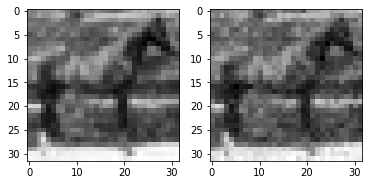

25  :  [0.8370555] 25
50  :  [0.88082147] 25
75  :  [0.8804902] 25
100  :  [0.8884896] 25
125  :  [0.88990605] 25
150  :  [0.8902563] 25
175  :  [0.8902563] 25
200  :  [0.8902563] 25
225  :  [0.8902563] 25
250  :  [0.8934318] 25
275  :  [0.8934318] 25
300  :  [0.8934318] 25
325  :  [0.89755386] 25
350  :  [0.90868664] 25
375  :  [0.90868664] 25
400  :  [0.90868664] 25
425  :  [0.91515917] 25
450  :  [0.91515917] 25
475  :  [0.91515917] 25
500  :  [0.91515917] 25
525  :  [0.9203959] 25
550  :  [0.92341673] 25
575  :  [0.9291018] 25
600  :  [0.9291018] 25
625  :  [0.9317356] 25
650  :  [0.9317356] 25
675  :  [0.9317356] 25
700  :  [0.93179876] 25
725  :  [0.93268454] 25
750  :  [0.93268454] 25
775  :  [0.9331207] 25
800  :  [0.9353354] 25
825  :  [0.93586546] 25
850  :  [0.9369425] 25
875  :  [0.9369425] 25
900  :  [0.93696856] 25
925  :  [0.93764985] 25
950  :  [0.93764985] 25
975  :  [0.9377351] 25
1000  :  [0.93786407] 25
1025  :  [0.9379767] 25
1050  :  [0.9381441] 25
1075  :  [0.938

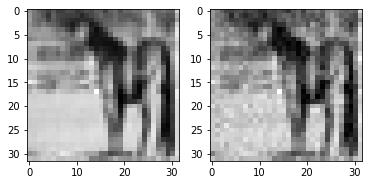

25  :  [0.7940285] 25
50  :  [0.7940285] 25
75  :  [0.86279356] 25
100  :  [0.87124634] 25
125  :  [0.87002015] 25
150  :  [0.9007021] 25
175  :  [0.9017959] 25
200  :  [0.9017959] 25
225  :  [0.9017959] 25
250  :  [0.9017959] 25
275  :  [0.9017959] 25
300  :  [0.9017959] 25
325  :  [0.9041057] 25
350  :  [0.9041057] 25
375  :  [0.9047925] 25
400  :  [0.9132511] 25
425  :  [0.9132511] 25
450  :  [0.9132511] 25
475  :  [0.9132511] 25
500  :  [0.9132511] 25
525  :  [0.9132511] 25
550  :  [0.91990924] 25
575  :  [0.91990924] 25
600  :  [0.9244485] 25
625  :  [0.9244485] 25
650  :  [0.9275818] 25
675  :  [0.9275818] 25
700  :  [0.9283248] 25
725  :  [0.9310557] 25
750  :  [0.9310557] 25
775  :  [0.9310557] 25
800  :  [0.9315907] 25
825  :  [0.9323799] 25
850  :  [0.9338572] 25
875  :  [0.93432784] 25
900  :  [0.93560266] 25
925  :  [0.93560266] 25
Time:  108.7913727760315  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


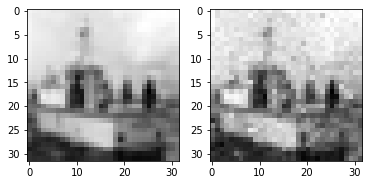

25  :  [0.9125991] 25
50  :  [0.91965604] 25
75  :  [0.9220303] 25
100  :  [0.9220303] 25
125  :  [0.92938614] 25
150  :  [0.9300482] 25
175  :  [0.9300554] 25
200  :  [0.9300554] 25
225  :  [0.9311767] 25
250  :  [0.93122053] 25
275  :  [0.9366952] 25
300  :  [0.9378568] 25
325  :  [0.9378568] 25
350  :  [0.938756] 25
375  :  [0.938756] 25
400  :  [0.9427738] 25
425  :  [0.9427738] 25
450  :  [0.94783866] 25
475  :  [0.94783866] 25
500  :  [0.94783866] 25
525  :  [0.9507444] 25
550  :  [0.9507444] 25
575  :  [0.9513167] 25
600  :  [0.9513167] 25
625  :  [0.9513167] 25
650  :  [0.9536122] 25
675  :  [0.9537943] 25
700  :  [0.95434815] 25
725  :  [0.95434815] 25
750  :  [0.954882] 25
775  :  [0.9556238] 25
800  :  [0.95620394] 25
Time:  95.62743616104126  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


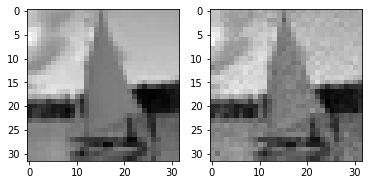

25  :  [0.91984] 25
50  :  [0.92141837] 25
75  :  [0.92152816] 25
100  :  [0.92854965] 25
125  :  [0.9313054] 25
150  :  [0.9313054] 25
175  :  [0.93896216] 25
200  :  [0.93896216] 25
225  :  [0.9440415] 25
250  :  [0.9440415] 25
275  :  [0.94754595] 25
300  :  [0.95101917] 25
325  :  [0.95101917] 25
350  :  [0.95101917] 25
375  :  [0.95101917] 25
400  :  [0.95403844] 25
425  :  [0.9587045] 25
450  :  [0.9594169] 25
475  :  [0.9594169] 25
500  :  [0.9613171] 25
525  :  [0.9636078] 25
550  :  [0.96581376] 25
575  :  [0.96581376] 25
600  :  [0.96581376] 25
625  :  [0.9663399] 25
650  :  [0.96698177] 25
675  :  [0.9692043] 25
700  :  [0.97062004] 25
725  :  [0.97062004] 25
750  :  [0.97062004] 25
775  :  [0.97064984] 25
800  :  [0.97064984] 25
Time:  94.78706049919128  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


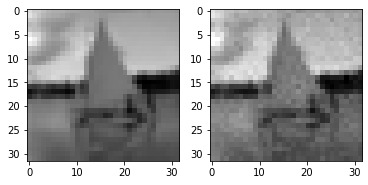

25  :  [0.7024758] 25
50  :  [0.81123734] 25
75  :  [0.81224] 25
100  :  [0.81224] 25
125  :  [0.8216812] 25
150  :  [0.820831] 25
175  :  [0.820831] 25
200  :  [0.820831] 25
225  :  [0.82452774] 25
250  :  [0.82453823] 25
275  :  [0.82453823] 25
300  :  [0.8250184] 25
325  :  [0.82453823] 25
350  :  [0.82453823] 25
375  :  [0.82453823] 25
400  :  [0.82453823] 25
425  :  [0.82892394] 25
450  :  [0.83414954] 25
475  :  [0.83414954] 25
500  :  [0.83414954] 25
525  :  [0.839818] 25
550  :  [0.84127057] 25
575  :  [0.8423441] 25
600  :  [0.8423441] 25
625  :  [0.8445331] 25
650  :  [0.8455516] 25
675  :  [0.8455516] 25
700  :  [0.84626615] 25
725  :  [0.8468168] 25
750  :  [0.84765923] 25
775  :  [0.85407877] 25
800  :  [0.8540758] 25
825  :  [0.8540758] 25
Time:  96.92222619056702  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


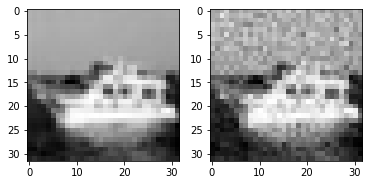

25  :  [0.9745737] 25
50  :  [0.9745737] 25
75  :  [0.97452027] 25
100  :  [0.97505796] 25
125  :  [0.9751313] 25
150  :  [0.9751313] 25
175  :  [0.97867584] 25
200  :  [0.97879684] 25
225  :  [0.9825481] 25
250  :  [0.9825481] 25
275  :  [0.9825481] 25
300  :  [0.9825481] 25
325  :  [0.98260134] 25
350  :  [0.98260134] 25
375  :  [0.98316586] 25
400  :  [0.9831891] 25
425  :  [0.98409677] 25
450  :  [0.98471653] 25
475  :  [0.9851981] 25
500  :  [0.9863193] 25
525  :  [0.9864212] 25
550  :  [0.98664516] 25
575  :  [0.9869093] 25
600  :  [0.9869093] 25
625  :  [0.9872768] 25
650  :  [0.9872768] 25
675  :  [0.9872896] 25
700  :  [0.9872896] 25
725  :  [0.9872896] 25
750  :  [0.987502] 25
775  :  [0.987502] 25
800  :  [0.9876137] 25
Time:  94.4198944568634  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


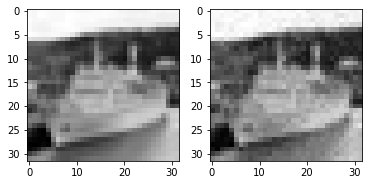

25  :  [0.86742073] 25
50  :  [0.86742073] 25
75  :  [0.8692359] 25
100  :  [0.8902306] 25
125  :  [0.8902306] 25
150  :  [0.8979216] 25
175  :  [0.9024272] 25
200  :  [0.9024272] 25
225  :  [0.9024272] 25
250  :  [0.9025701] 25
275  :  [0.9025701] 25
300  :  [0.9025701] 25
325  :  [0.9025701] 25
350  :  [0.9025701] 25
375  :  [0.91010433] 25
400  :  [0.91015375] 25
425  :  [0.91015375] 25
450  :  [0.9152458] 25
475  :  [0.9184703] 25
500  :  [0.9184703] 25
525  :  [0.9184703] 25
550  :  [0.9266614] 25
575  :  [0.9289129] 25
600  :  [0.9289307] 25
625  :  [0.9289307] 25
650  :  [0.9338341] 25
675  :  [0.9338341] 25
700  :  [0.9369737] 25
725  :  [0.94400537] 25
750  :  [0.9458967] 25
775  :  [0.9458967] 25
800  :  [0.9458967] 25
825  :  [0.9458967] 25
850  :  [0.9458967] 25
875  :  [0.9501538] 25
Time:  109.81907439231873  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [0]


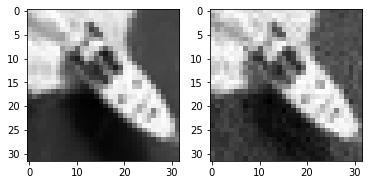

25  :  [0.78640765] 25
50  :  [0.78640765] 25
75  :  [0.8153199] 25
100  :  [0.8153199] 25
125  :  [0.8153199] 25
150  :  [0.8153199] 25
175  :  [0.8153199] 25
200  :  [0.8153199] 25
225  :  [0.8153199] 25
250  :  [0.8153199] 25
275  :  [0.8153199] 25
300  :  [0.8153199] 25
325  :  [0.8153199] 25
350  :  [0.8201776] 25
375  :  [0.8242669] 25
400  :  [0.8242669] 25
425  :  [0.8278878] 25
450  :  [0.8278878] 25
475  :  [0.8278878] 25
500  :  [0.8278878] 25
525  :  [0.8278878] 25
550  :  [0.8278878] 25
575  :  [0.8278878] 25
600  :  [0.8278878] 25
625  :  [0.8278878] 25
650  :  [0.8278878] 25
675  :  [0.8349067] 25
700  :  [0.8387784] 25
725  :  [0.840469] 25
750  :  [0.840469] 25
775  :  [0.84250116] 25
800  :  [0.84250116] 25
825  :  [0.84250116] 25
850  :  [0.8426831] 25
Time:  101.92681360244751  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


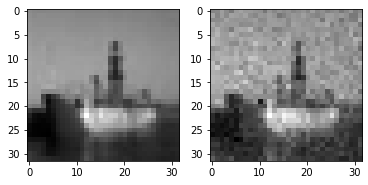

25  :  [0.9566655] 25
50  :  [0.95932436] 25
75  :  [0.96032] 25
100  :  [0.96029866] 25
125  :  [0.96403027] 25
150  :  [0.96403027] 25
175  :  [0.96403027] 25
200  :  [0.96403027] 25
225  :  [0.96403027] 25
250  :  [0.96403027] 25
275  :  [0.96403027] 25
300  :  [0.96403027] 25
325  :  [0.96403027] 25
350  :  [0.96403027] 25
375  :  [0.96403027] 25
400  :  [0.96555036] 25
425  :  [0.96586096] 25
450  :  [0.96555036] 25
475  :  [0.9691205] 25
500  :  [0.9691194] 25
525  :  [0.9703393] 25
550  :  [0.9703393] 25
575  :  [0.9703393] 25
600  :  [0.9715953] 25
625  :  [0.9738672] 25
650  :  [0.9741646] 25
675  :  [0.97542256] 25
700  :  [0.9754635] 25
725  :  [0.9770636] 25
750  :  [0.97711957] 25
775  :  [0.97765696] 25
800  :  [0.97889936] 25
Time:  96.06614422798157  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


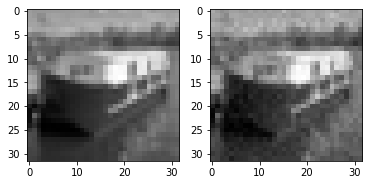

25  :  [0.926828] 25
50  :  [0.9272085] 25
75  :  [0.9325869] 25
100  :  [0.932701] 25
125  :  [0.9408709] 25
150  :  [0.9473772] 25
175  :  [0.9473772] 25
200  :  [0.9473772] 25
225  :  [0.9473772] 25
250  :  [0.9473772] 25
275  :  [0.95228255] 25
300  :  [0.95228255] 25
325  :  [0.95291823] 25
350  :  [0.9529489] 25
375  :  [0.9550003] 25
400  :  [0.9550003] 25
425  :  [0.9564109] 25
450  :  [0.9587183] 25
475  :  [0.9587586] 25
500  :  [0.96046996] 25
525  :  [0.9605044] 25
550  :  [0.96145856] 25
575  :  [0.96145856] 25
600  :  [0.963812] 25
625  :  [0.963812] 25
650  :  [0.96447146] 25
675  :  [0.9651315] 25
700  :  [0.96548724] 25
725  :  [0.96548724] 25
750  :  [0.96548724] 25
775  :  [0.96548724] 25
800  :  [0.96548724] 25
Time:  95.76790642738342  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


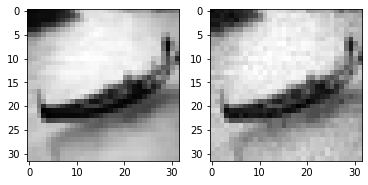

25  :  [0.8452308] 25
50  :  [0.84911877] 25
75  :  [0.85907817] 25
100  :  [0.8610854] 25
125  :  [0.8652314] 25
150  :  [0.8652314] 25
175  :  [0.8652314] 25
200  :  [0.8663374] 25
225  :  [0.8663374] 25
250  :  [0.8676133] 25
275  :  [0.86775476] 25
300  :  [0.87470436] 25
325  :  [0.8795595] 25
350  :  [0.88123286] 25
375  :  [0.8826335] 25
400  :  [0.8826335] 25
425  :  [0.88512063] 25
450  :  [0.8902965] 25
475  :  [0.8902965] 25
500  :  [0.8902965] 25
525  :  [0.8907262] 25
550  :  [0.8907262] 25
575  :  [0.8907262] 25
600  :  [0.89169514] 25
625  :  [0.8941497] 25
650  :  [0.8952933] 25
675  :  [0.8958782] 25
700  :  [0.8962133] 25
725  :  [0.8963094] 25
750  :  [0.8971088] 25
775  :  [0.89766717] 25
800  :  [0.8987508] 25
Time:  94.00576186180115  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


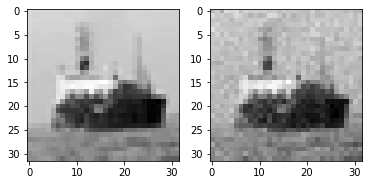

25  :  [0.9304642] 25
50  :  [0.9304642] 25
75  :  [0.9304642] 25
100  :  [0.9363567] 25
125  :  [0.9357598] 25
150  :  [0.9357598] 25
175  :  [0.9357598] 25
200  :  [0.9357598] 25
225  :  [0.9357598] 25
250  :  [0.9357598] 25
275  :  [0.93687356] 25
300  :  [0.93785095] 25
325  :  [0.9378224] 25
350  :  [0.93809044] 25
375  :  [0.93819773] 25
400  :  [0.93821585] 25
425  :  [0.93819773] 25
450  :  [0.941993] 25
475  :  [0.9472121] 25
500  :  [0.9472121] 25
525  :  [0.9472121] 25
550  :  [0.9576285] 25
575  :  [0.95759803] 25
600  :  [0.95759803] 25
625  :  [0.9592582] 25
650  :  [0.95968425] 25
675  :  [0.961221] 25
700  :  [0.961221] 25
725  :  [0.961221] 25
750  :  [0.961221] 25
775  :  [0.961221] 25
800  :  [0.9617291] 25
825  :  [0.9630778] 25
850  :  [0.9630778] 25
875  :  [0.9630778] 25
900  :  [0.96417195] 25
925  :  [0.96585125] 25
950  :  [0.96585125] 25
975  :  [0.9668313] 25
1000  :  [0.96793723] 25
1025  :  [0.96882385] 25
1050  :  [0.96882385] 25
1075  :  [0.96882385] 25


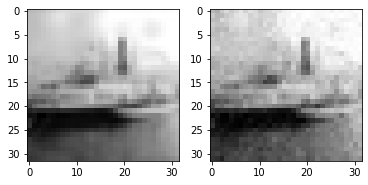

25  :  [0.95354176] 25
50  :  [0.95354176] 25
75  :  [0.95365417] 25
100  :  [0.95365417] 25
125  :  [0.95365417] 25
150  :  [0.95365417] 25
175  :  [0.95365417] 25
200  :  [0.95365417] 25
225  :  [0.95365417] 25
250  :  [0.95365417] 25
275  :  [0.95365417] 25
300  :  [0.95365417] 25
325  :  [0.95365417] 25
350  :  [0.95365417] 25
375  :  [0.95365417] 25
400  :  [0.95365417] 25
425  :  [0.95393205] 25
450  :  [0.9616121] 25
475  :  [0.9616121] 25
500  :  [0.9661745] 25
525  :  [0.96628237] 25
550  :  [0.96628237] 25
575  :  [0.97035563] 25
600  :  [0.97035563] 25
625  :  [0.97035563] 25
650  :  [0.97035563] 25
675  :  [0.970732] 25
700  :  [0.97074807] 25
725  :  [0.97219837] 25
750  :  [0.97219837] 25
775  :  [0.97219837] 25
800  :  [0.97219837] 25
Time:  92.32615804672241  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


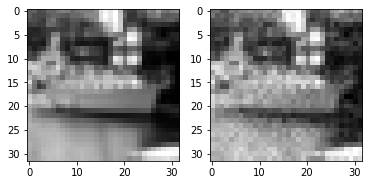

25  :  [0.7770438] 25
50  :  [0.7770438] 25
75  :  [0.7770438] 25
100  :  [0.7871594] 25
125  :  [0.7871594] 25
150  :  [0.7871594] 25
175  :  [0.7871594] 25
200  :  [0.8029549] 25
225  :  [0.8070855] 25
250  :  [0.8213359] 25
275  :  [0.8213359] 25
300  :  [0.8324363] 25
325  :  [0.8324363] 25
350  :  [0.8348807] 25
375  :  [0.8369518] 25
400  :  [0.84177184] 25
425  :  [0.85095227] 25
450  :  [0.85095227] 25
475  :  [0.85095227] 25
500  :  [0.8520627] 25
525  :  [0.85519844] 25
550  :  [0.8617922] 25
575  :  [0.8619303] 25
600  :  [0.8619303] 25
625  :  [0.8619303] 25
650  :  [0.86674106] 25
675  :  [0.8699523] 25
700  :  [0.8699523] 25
725  :  [0.8699523] 25
750  :  [0.87181467] 25
775  :  [0.87181467] 25
800  :  [0.87324584] 25
825  :  [0.8739475] 25
850  :  [0.8739475] 25
875  :  [0.8739475] 25
900  :  [0.8742598] 25
925  :  [0.87457263] 25
950  :  [0.87488925] 25
975  :  [0.8750019] 25
1000  :  [0.8754365] 25
1025  :  [0.8754365] 25
1050  :  [0.87588096] 25
1075  :  [0.87588096] 

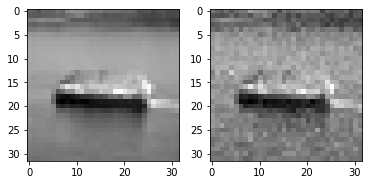

25  :  [0.8797579] 25
50  :  [0.92515385] 25
75  :  [0.9382136] 25
100  :  [0.9458078] 25
125  :  [0.9465853] 25
150  :  [0.9465853] 25
175  :  [0.9560032] 25
200  :  [0.9560032] 25
225  :  [0.9585674] 25
250  :  [0.9658073] 25
275  :  [0.9658073] 25
300  :  [0.9658073] 25
325  :  [0.9658073] 25
350  :  [0.96613383] 25
375  :  [0.969104] 25
400  :  [0.97139436] 25
425  :  [0.971679] 25
450  :  [0.971679] 25
475  :  [0.97314775] 25
500  :  [0.9774302] 25
525  :  [0.9774302] 25
550  :  [0.9774302] 25
575  :  [0.9774302] 25
600  :  [0.9774302] 25
625  :  [0.97845995] 25
650  :  [0.97845995] 25
675  :  [0.97882926] 25
700  :  [0.97882926] 25
725  :  [0.97882926] 25
750  :  [0.97882926] 25
775  :  [0.97882926] 25
800  :  [0.97886544] 25
825  :  [0.97915757] 25
850  :  [0.9792416] 25
Time:  98.56580829620361  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


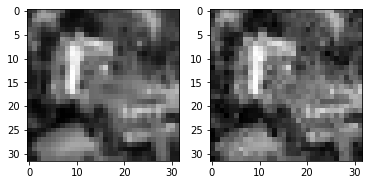

25  :  [0.943826] 25
50  :  [0.943826] 25
75  :  [0.94522005] 25
100  :  [0.94522005] 25
125  :  [0.94522005] 25
150  :  [0.94522005] 25
175  :  [0.94522005] 25
200  :  [0.94522005] 25
225  :  [0.94522005] 25
250  :  [0.94522005] 25
275  :  [0.94522005] 25
300  :  [0.94522005] 25
325  :  [0.9470079] 25
350  :  [0.950543] 25
375  :  [0.950543] 25
400  :  [0.950543] 25
425  :  [0.950543] 25
450  :  [0.9617585] 25
475  :  [0.9617585] 25
500  :  [0.9617585] 25
525  :  [0.9617585] 25
550  :  [0.9617585] 25
575  :  [0.9617585] 25
600  :  [0.9617585] 25
625  :  [0.9617585] 25
650  :  [0.9617585] 25
675  :  [0.9617585] 25
700  :  [0.9617585] 25
725  :  [0.9617585] 25
750  :  [0.9617585] 25
775  :  [0.9617585] 25
800  :  [0.9621228] 25
825  :  [0.9621228] 25
850  :  [0.9624202] 25
875  :  [0.9625149] 25
900  :  [0.96321666] 25
925  :  [0.96321666] 25
950  :  [0.96321666] 25
975  :  [0.9664475] 25
1000  :  [0.96861076] 25
1025  :  [0.96894807] 25
1050  :  [0.9717611] 25
1075  :  [0.9717611] 25
1

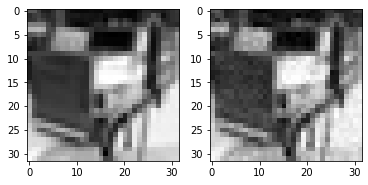

25  :  [0.94098365] 25
50  :  [0.94098365] 25
75  :  [0.943599] 25
100  :  [0.943599] 25
125  :  [0.943599] 25
150  :  [0.943599] 25
175  :  [0.943599] 25
200  :  [0.943599] 25
225  :  [0.943599] 25
250  :  [0.943599] 25
275  :  [0.943599] 25
300  :  [0.943599] 25
325  :  [0.943599] 25
350  :  [0.943599] 25
375  :  [0.943599] 25
400  :  [0.943599] 25
425  :  [0.943599] 25
450  :  [0.9512155] 25
475  :  [0.9512155] 25
500  :  [0.9512155] 25
525  :  [0.9512155] 25
550  :  [0.9512155] 25
575  :  [0.9512155] 25
600  :  [0.9512155] 25
625  :  [0.9523059] 25
650  :  [0.9536694] 25
675  :  [0.95486856] 25
700  :  [0.9555315] 25
725  :  [0.95607257] 25
750  :  [0.9566201] 25
775  :  [0.95743465] 25
800  :  [0.95855796] 25
Time:  90.6330931186676  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


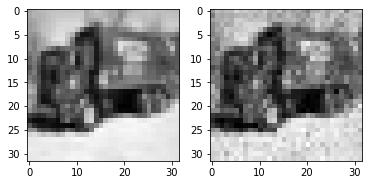

25  :  [0.8954958] 25
50  :  [0.8998456] 25
75  :  [0.899815] 25
100  :  [0.899815] 25
125  :  [0.899815] 25
150  :  [0.899815] 25
175  :  [0.899815] 25
200  :  [0.899815] 25
225  :  [0.9016657] 25
250  :  [0.9016657] 25
275  :  [0.9016657] 25
300  :  [0.9016657] 25
325  :  [0.9016657] 25
350  :  [0.9016657] 25
375  :  [0.9035512] 25
400  :  [0.90375626] 25
425  :  [0.90375626] 25
450  :  [0.90375626] 25
475  :  [0.90375626] 25
500  :  [0.9048595] 25
525  :  [0.9058745] 25
550  :  [0.9058745] 25
575  :  [0.9058745] 25
600  :  [0.9058745] 25
625  :  [0.9061717] 25
650  :  [0.90797913] 25
675  :  [0.9084686] 25
700  :  [0.9084686] 25
725  :  [0.9084686] 25
750  :  [0.9084686] 25
775  :  [0.9084686] 25
800  :  [0.91177225] 25
Time:  93.22384810447693  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [2]


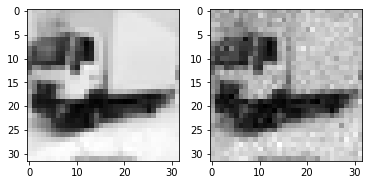

25  :  [0.882147] 25
50  :  [0.882147] 25
75  :  [0.8897599] 25
100  :  [0.8909456] 25
125  :  [0.8972868] 25
150  :  [0.89823914] 25
175  :  [0.89823914] 25
200  :  [0.9050722] 25
225  :  [0.90508866] 25
250  :  [0.91042423] 25
275  :  [0.90987885] 25
300  :  [0.90987885] 25
325  :  [0.90987885] 25
350  :  [0.9102478] 25
375  :  [0.9098469] 25
400  :  [0.9098469] 25
425  :  [0.9098469] 25
450  :  [0.9098469] 25
475  :  [0.9098469] 25
500  :  [0.9115149] 25
525  :  [0.91526675] 25
550  :  [0.91526675] 25
575  :  [0.91526675] 25
600  :  [0.91526675] 25
625  :  [0.91526675] 25
650  :  [0.91526675] 25
675  :  [0.91526675] 25
700  :  [0.91561687] 25
725  :  [0.91949797] 25
750  :  [0.91949797] 25
775  :  [0.92000276] 25
800  :  [0.9240879] 25
Time:  90.46844124794006  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [2]


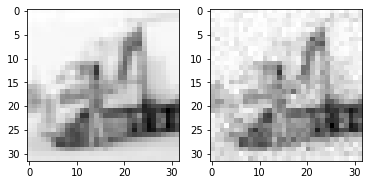

25  :  [0.8518339] 25
50  :  [0.854681] 25
75  :  [0.87526673] 25
100  :  [0.8765223] 25
125  :  [0.8765223] 25
150  :  [0.8765223] 25
175  :  [0.8765223] 25
200  :  [0.8765223] 25
225  :  [0.8765223] 25
250  :  [0.8765223] 25
275  :  [0.8765223] 25
300  :  [0.8765223] 25
325  :  [0.8795123] 25
350  :  [0.8797535] 25
375  :  [0.8889724] 25
400  :  [0.8889724] 25
425  :  [0.8943542] 25
450  :  [0.89656776] 25
475  :  [0.89656776] 25
500  :  [0.89656776] 25
525  :  [0.89656776] 25
550  :  [0.9034325] 25
575  :  [0.90351295] 25
600  :  [0.90353525] 25
625  :  [0.90426576] 25
650  :  [0.9048077] 25
675  :  [0.9048077] 25
700  :  [0.9048077] 25
725  :  [0.9048077] 25
750  :  [0.9048077] 25
775  :  [0.9049066] 25
800  :  [0.9051746] 25
825  :  [0.9051746] 25
850  :  [0.90627164] 25
Time:  96.46448874473572  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


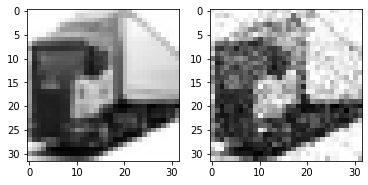

25  :  [0.8724401] 25
50  :  [0.8724401] 25
75  :  [0.8199225] 25
100  :  [0.8199225] 25
125  :  [0.87084305] 25
150  :  [0.9279551] 25
175  :  [0.92622113] 25
200  :  [0.92622113] 25
225  :  [0.92622113] 25
250  :  [0.92622113] 25
275  :  [0.92622113] 25
300  :  [0.92622113] 25
325  :  [0.93339205] 25
350  :  [0.93289685] 25
375  :  [0.93289685] 25
400  :  [0.93289685] 25
425  :  [0.93289685] 25
450  :  [0.93289685] 25
475  :  [0.93289685] 25
500  :  [0.93289685] 25
525  :  [0.9340377] 25
550  :  [0.9340377] 25
575  :  [0.9340377] 25
600  :  [0.9343362] 25
625  :  [0.9343362] 25
650  :  [0.9354603] 25
675  :  [0.93545675] 25
700  :  [0.9401499] 25
725  :  [0.9401499] 25
750  :  [0.9401499] 25
775  :  [0.9401499] 25
800  :  [0.9401499] 25
825  :  [0.9420785] 25
850  :  [0.942113] 25
875  :  [0.942113] 25
900  :  [0.94256926] 25
925  :  [0.9431051] 25
Time:  105.60181546211243  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [4]


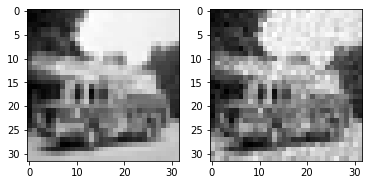

25  :  [0.94754344] 25
50  :  [0.94754344] 25
75  :  [0.9540607] 25
100  :  [0.9540318] 25
125  :  [0.9540318] 25
150  :  [0.9540318] 25
175  :  [0.9540318] 25
200  :  [0.9540318] 25
225  :  [0.9594984] 25
250  :  [0.9598802] 25
275  :  [0.95991194] 25
300  :  [0.9611473] 25
325  :  [0.9611473] 25
350  :  [0.9611473] 25
375  :  [0.9611473] 25
400  :  [0.9611473] 25
425  :  [0.9611473] 25
450  :  [0.9611473] 25
475  :  [0.9611473] 25
500  :  [0.96117854] 25
525  :  [0.96117854] 25
550  :  [0.96117854] 25
575  :  [0.9658518] 25
600  :  [0.96689385] 25
625  :  [0.96689385] 25
650  :  [0.96730787] 25
675  :  [0.96824026] 25
700  :  [0.96824026] 25
725  :  [0.96824026] 25
750  :  [0.9710358] 25
775  :  [0.9727706] 25
800  :  [0.9727706] 25
Time:  92.58750891685486  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


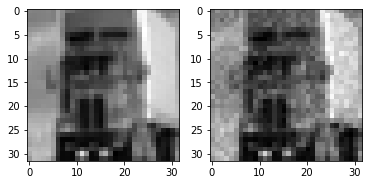

25  :  [0.92599404] 25
50  :  [0.92599404] 25
75  :  [0.92599404] 25
100  :  [0.92599404] 25
125  :  [0.92599404] 25
150  :  [0.92599404] 25
175  :  [0.92599404] 25
200  :  [0.9309757] 25
225  :  [0.9309757] 25
250  :  [0.9460391] 25
275  :  [0.9486594] 25
300  :  [0.9532565] 25
325  :  [0.95305] 25
350  :  [0.95305] 25
375  :  [0.95305] 25
400  :  [0.95305] 25
425  :  [0.95305] 25
450  :  [0.9549488] 25
475  :  [0.95492953] 25
500  :  [0.95492953] 25
525  :  [0.95492953] 25
550  :  [0.95771] 25
575  :  [0.9604536] 25
600  :  [0.9604536] 25
625  :  [0.96333337] 25
650  :  [0.963823] 25
675  :  [0.963823] 25
700  :  [0.963823] 25
725  :  [0.96531916] 25
750  :  [0.965562] 25
775  :  [0.96628946] 25
800  :  [0.9666637] 25
825  :  [0.9675375] 25
850  :  [0.9675375] 25
875  :  [0.9675375] 25
900  :  [0.9678272] 25
925  :  [0.9678272] 25
950  :  [0.9678272] 25
975  :  [0.967943] 25
1000  :  [0.967943] 25
1025  :  [0.967943] 25
Time:  116.23213815689087  seconds
Original class:  9
Prediction

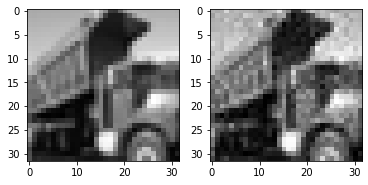

25  :  [0.96955913] 25
50  :  [0.97178686] 25
75  :  [0.97210145] 25
100  :  [0.97210145] 25
125  :  [0.972217] 25
150  :  [0.972217] 25
175  :  [0.9731817] 25
200  :  [0.97321784] 25
225  :  [0.9748429] 25
250  :  [0.9751279] 25
275  :  [0.975986] 25
300  :  [0.975986] 25
325  :  [0.975986] 25
350  :  [0.9768615] 25
375  :  [0.9769366] 25
400  :  [0.97936535] 25
425  :  [0.9793683] 25
450  :  [0.9793683] 25
475  :  [0.97939456] 25
500  :  [0.9804039] 25
525  :  [0.98042256] 25
550  :  [0.9807622] 25
575  :  [0.9807621] 25
600  :  [0.9815792] 25
625  :  [0.9815724] 25
650  :  [0.9818083] 25
675  :  [0.9828199] 25
700  :  [0.9828199] 25
725  :  [0.9828199] 25
750  :  [0.9832759] 25
775  :  [0.9832759] 25
800  :  [0.98331404] 25
Time:  93.4626567363739  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


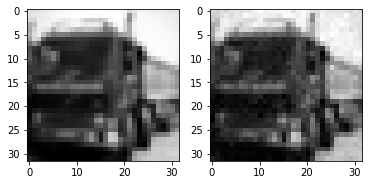

25  :  [0.96253014] 25
50  :  [0.96253014] 25
75  :  [0.96253014] 25
100  :  [0.96253014] 25
125  :  [0.96253014] 25
150  :  [0.9630557] 25
175  :  [0.96531427] 25
200  :  [0.9714472] 25
225  :  [0.9714472] 25
250  :  [0.9714472] 25
275  :  [0.9720588] 25
300  :  [0.9720583] 25
325  :  [0.9736035] 25
350  :  [0.9755504] 25
375  :  [0.9794241] 25
400  :  [0.9794241] 25
425  :  [0.9799691] 25
450  :  [0.9821914] 25
475  :  [0.982273] 25
500  :  [0.9830504] 25
525  :  [0.98396015] 25
550  :  [0.98396015] 25
575  :  [0.98396015] 25
600  :  [0.98396015] 25
625  :  [0.98396015] 25
650  :  [0.98442197] 25
675  :  [0.98451763] 25
700  :  [0.9847225] 25
725  :  [0.9848354] 25
750  :  [0.98494184] 25
775  :  [0.98495334] 25
800  :  [0.9850768] 25
Time:  90.23798966407776  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


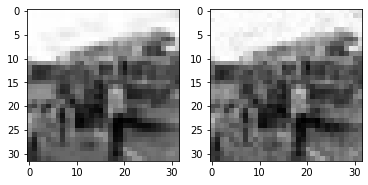

25  :  [0.929234] 25
50  :  [0.93118036] 25
75  :  [0.9365432] 25
100  :  [0.9442319] 25
125  :  [0.9442489] 25
150  :  [0.94606787] 25
175  :  [0.94729924] 25
200  :  [0.94729924] 25
225  :  [0.94986963] 25
250  :  [0.95474505] 25
275  :  [0.95474505] 25
300  :  [0.9574072] 25
325  :  [0.9596499] 25
350  :  [0.9596499] 25
375  :  [0.9596499] 25
400  :  [0.96137476] 25
425  :  [0.96137476] 25
450  :  [0.96137476] 25
475  :  [0.96324396] 25
500  :  [0.9638634] 25
525  :  [0.9646081] 25
550  :  [0.96620035] 25
575  :  [0.9668201] 25
600  :  [0.96698254] 25
625  :  [0.9674943] 25
650  :  [0.96866375] 25
675  :  [0.9689301] 25
700  :  [0.9695686] 25
725  :  [0.97038496] 25
750  :  [0.9705547] 25
775  :  [0.97139794] 25
800  :  [0.97139794] 25
Time:  90.15446710586548  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


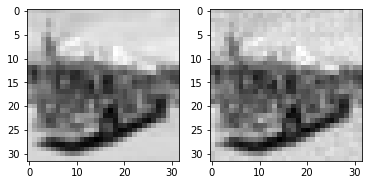

25  :  [0.95922995] 25
50  :  [0.95922995] 25
75  :  [0.95922995] 25
100  :  [0.95922995] 25
125  :  [0.95922995] 25
150  :  [0.95922995] 25
175  :  [0.95922995] 25
200  :  [0.9610752] 25
225  :  [0.9610752] 25
250  :  [0.9610752] 25
275  :  [0.966973] 25
300  :  [0.966972] 25
325  :  [0.966972] 25
350  :  [0.9678282] 25
375  :  [0.9678807] 25
400  :  [0.97181517] 25
425  :  [0.97181517] 25
450  :  [0.97181517] 25
475  :  [0.97181517] 25
500  :  [0.97181517] 25
525  :  [0.97181517] 25
550  :  [0.97181517] 25
575  :  [0.97550195] 25
600  :  [0.97550195] 25
625  :  [0.97550195] 25
650  :  [0.97550195] 25
675  :  [0.97550195] 25
700  :  [0.97550195] 25
725  :  [0.97550195] 25
750  :  [0.97550195] 25
775  :  [0.97550195] 25
800  :  [0.9755571] 25
Time:  90.77817225456238  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


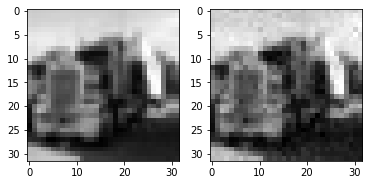

25  :  [0.97136426] 25
50  :  [0.97136426] 25
75  :  [0.97247005] 25
100  :  [0.97247446] 25
125  :  [0.97247446] 25
150  :  [0.9743247] 25
175  :  [0.9749014] 25
200  :  [0.9753117] 25
225  :  [0.97753364] 25
250  :  [0.97753364] 25
275  :  [0.97753364] 25
300  :  [0.97753364] 25
325  :  [0.97807604] 25
350  :  [0.9792744] 25
375  :  [0.9792712] 25
400  :  [0.9804046] 25
425  :  [0.9811723] 25
450  :  [0.98144853] 25
475  :  [0.9814439] 25
500  :  [0.98216677] 25
525  :  [0.982406] 25
550  :  [0.982406] 25
575  :  [0.98310673] 25
600  :  [0.983565] 25
625  :  [0.9850545] 25
650  :  [0.9850545] 25
675  :  [0.9854606] 25
700  :  [0.9854572] 25
725  :  [0.9854572] 25
750  :  [0.9854572] 25
775  :  [0.9854572] 25
800  :  [0.9854698] 25
Time:  90.26273798942566  seconds
Original class:  9
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


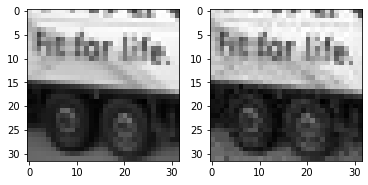

In [21]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((32*32,1)),adversarial_y[adv_ind],32*32)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,32,32,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Original class: ",adversarial_y[adv_ind][0])
  print("Prediction for normal image: ", np.argmax(model.predict(adversarial[adv_ind].reshape(1,32,32,1) / 255.0),axis=1))
  print("Prediction for adversarial image: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(32,32),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(32,32),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best.reshape((32,32,1))

airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

In [0]:
import pickle

In [0]:
file_ = open('adv_de_cnn_cifar_ssim', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [24]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

245.9047396183014
90.15446710586548
124.17354973814541
33.027178087950205


In [25]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2067
800
1027.9924812030076
275.02993675031314


In [26]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

23.50311665406684
5.495245273332605
11.067998408716774
2.993146572179597
